# SEIR Model, LHS Sampling, and Surrogate Training with LSTM & GRU

In this notebook we simulate an age‐structured SEIR model for infectious disease dynamics, explore the parameter space using Latin Hypercube Sampling (LHS), and train surrogate models using Recurrent Neural Networks (RNNs) – specifically, Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) architectures.

The notebook is divided into several sections:

1. **Infectious Disease Modelling Theory:** An introduction to compartmental models such as SEIR.
2. **Surrogate Models:** Why we build surrogates and how they enable rapid approximation of expensive simulations.
3. **RNNs for Time Series Prediction:** An overview of RNNs with a focus on LSTM and GRU cells, including the relevant mathematics.
4. **Simulation, Parameter Sampling and Surrogate Training:** Code sections for the SEIR model, LHS sampling, and training of surrogate models.

Let’s get started!

## 1. Infectious Disease (ID) Modelling Theory

Infectious disease modelling is a key tool for understanding and predicting the spread of diseases in populations. One common approach is to use **compartmental models**. In these models, the population is divided into distinct groups (or compartments) based on disease status. 

### The SEIR Model

The SEIR model is one of the most widely used compartmental models. It divides the population into:

- **S (Susceptible):** Individuals who can contract the disease.
- **E (Exposed):** Individuals who have been infected but are not yet infectious.
- **I (Infectious):** Individuals who can transmit the disease to others.
- **R (Recovered):** Individuals who have recovered and may have immunity.

An additional compartment, **C (Cumulative incidence)**, is sometimes added to keep track of the total number of new infections. 

The dynamics of these compartments are usually described by a system of differential equations. In our model, we further **stratify by age** (17 age groups) to capture heterogeneous mixing patterns.

## 2. Surrogate Models and RNNs

### Why Surrogate Models?

The SEIR model in this notebook is not a complex mathematical model. However, infectious disease models used to support public-health policy are often computationally expensive, and can sometimes take hours or days to run. Researchers often also need to exploring large parameter spaces to correctly explore the undertainty in key ID model parameters, such as the duration of infectiousness or future changes in transmission as a result of public-health and social measures. Further, ID models are often not just described by systems of differential equations (as used in this notebook) but often are stochastic, agent-based models that are computationally very challenging to fit to data for parameter inference.

**Surrogate models** are fast, approximate generative models that are trained to emulate the output of these expensive simulations. They allow rapid predictions, uncertainty quantification, and support more real-time public-health decisions. Additionally, the end-to-end differntiability of surrogate models allows them to be used for computationally tractable model fitting. 

### Recurrent Neural Networks (RNNs)

RNNs are designed for sequential data (e.g., time series) by maintaining a hidden state that carries information from previous time steps. Two popular RNN architectures are **LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)**. 

#### LSTM Equations

The LSTM cell updates are given by:

$$\begin{aligned}
i_t &= \sigma(W_{xi} x_t + W_{hi} h_{t-1} + b_i) \\
f_t &= \sigma(W_{xf} x_t + W_{hf} h_{t-1} + b_f) \\
o_t &= \sigma(W_{xo} x_t + W_{ho} h_{t-1} + b_o) \\
\tilde{c}_t &= \tanh(W_{xc} x_t + W_{hc} h_{t-1} + b_c) \\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
h_t &= o_t \odot \tanh(c_t) 
\end{aligned}$$

Here, $i_t$, $f_t$, and $o_t$ are the input, forget, and output gates respectively, and $c_t$ is the cell state.

#### GRU Equations

The GRU cell updates are somewhat simpler:

$$\begin{aligned}
z_t &= \sigma(W_{xz} x_t + W_{hz} h_{t-1} + b_z) \\
r_t &= \sigma(W_{xr} x_t + W_{hr} h_{t-1} + b_r) \\
\tilde{h}_t &= \tanh(W_{xh} x_t + r_t \odot (W_{hh} h_{t-1}) + b_h) \\
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}$$

These mechanisms allow the network to capture long-term dependencies and selectively forget or update information.

### What Does the Surrogate Do?

In our setting, the surrogate model (using either LSTM or GRU) takes as input a sequence that includes:

- A normalized time feature.
- A set of simulation parameters (e.g. latent period, infectious period, etc.) repeated at each time step.

It then predicts the time series output (e.g., total incidence over time) that would be produced by the full SEIR simulation. By training on many simulation runs, the surrogate learns to approximate the mapping from parameters to outcomes very quickly.

In [43]:
# -------------------------------------------------------- #
# 1. Load in packages
# -------------------------------------------------------- #

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
import pandas as pd

# Use inline plotting for Jupyter
%matplotlib inline

In [44]:
# -------------------------------------------------------- #
# 2. SEIR Model Definition
# -------------------------------------------------------- #

class SEIR:
    """
    A class for simulating a deterministic age‐structured SEIR model with 17 age groups.
    
    Compartments per age group:
      - S: Susceptible
      - E: Exposed (infected but not yet infectious)
      - I: Infectious
      - R: Recovered
      - C: Cumulative incidence (number of new infections entering I)
    """

    def __init__(
        self,
        contact_matrix,
        latent_period,
        infectious_period,
        immunity_period, 
        N,
        I0,
        seed=None,
    ):
        """
        Initialise the model with user‐provided parameters.
        """
        self.n_age = 17
        self.contact_matrix = np.array(contact_matrix)

        self.latent_period = latent_period
        self.infectious_period = infectious_period
        self.immunity_period = immunity_period
        self.sigma = 1.0 / latent_period      # rate of leaving the exposed compartment
        self.gamma = 1.0 / infectious_period  # recovery rate
        self.rho = 1.0 / immunity_period      # rate of loss of immunity

        N = np.array(N)
        if N.shape[0] != self.n_age:
            raise ValueError(f"N must be of length {self.n_age}.")

        # Allocate I0 infections among age groups 20-60 (indices 4 to 11)
        eligible_indices = np.arange(4, 12)
        I_init = np.zeros(self.n_age, dtype=int)
        rng = np.random.default_rng(seed)
        if I0 > 0:
            allocation = rng.multinomial(I0, np.full(len(eligible_indices), 1/len(eligible_indices)))
            I_init[eligible_indices] = allocation

        S_init = N - I_init
        if np.any(S_init < 0):
            raise ValueError("Allocated initial infections exceed population in one or more groups.")

        E_init = np.zeros(self.n_age, dtype=int)
        R_init = np.zeros(self.n_age, dtype=int)

        self.initial_conditions = {
            'S': S_init.astype(float),
            'E': E_init.astype(float),
            'I': I_init.astype(float),
            'R': R_init.astype(float)
        }

        self.pop_age = S_init + E_init + I_init + R_init

        self.initial_C = np.zeros(self.n_age)
        self.y0 = np.concatenate([
            self.initial_conditions['S'],
            self.initial_conditions['E'],
            self.initial_conditions['I'],
            self.initial_conditions['R'],
            self.initial_C
        ])

        eigenvalues = eigvals(self.contact_matrix)
        self.denom = np.max(np.abs(eigenvalues))

        self.results = None

    def get_current_Rt(self, t):
        if t < self.tt_Rt[1]:
            return self.Rt[0]
        elif t < self.tt_Rt[2]:
            return self.Rt[1]
        else:
            return self.Rt[2]

    def beta_t(self, t):
        current_Rt = self.get_current_Rt(t)
        return current_Rt / (self.infectious_period * self.denom)

    def deriv(self, t, y):
        S = y[0:self.n_age]
        E = y[self.n_age:2*self.n_age]
        I = y[2*self.n_age:3*self.n_age]
        R = y[3*self.n_age:4*self.n_age]
        C = y[4*self.n_age:5*self.n_age]

        beta = self.beta_t(t)
        lambda_vec = beta * np.dot(self.contact_matrix, I / self.pop_age)

        dS = -lambda_vec * S + self.rho * R
        dE = lambda_vec * S - self.sigma * E
        dI = self.sigma * E - self.gamma * I
        dR = self.gamma * I - self.rho * R
        dC = self.sigma * E

        return np.concatenate([dS, dE, dI, dR, dC])

    def run(self, t_end, Rt, tt_Rt, dt=0.1):
        self.Rt = np.array(Rt)
        self.tt_Rt = np.array(tt_Rt)
        if len(self.Rt) != 3 or len(self.tt_Rt) != 3:
            raise ValueError("Rt and tt_Rt must be of length 3.")

        t_eval = np.arange(0, t_end, dt)
        sol = solve_ivp(self.deriv, [0, t_end], self.y0, t_eval=t_eval, vectorized=False)
        if not sol.success:
            raise RuntimeError("Integration failed.")
        self.results = sol
        return sol

    def get_output(self):
        if self.results is None:
            raise RuntimeError("No simulation results available. Run the simulation first.")

        t_all = self.results.t
        int_days = np.floor(t_all).astype(int)
        unique_days = np.unique(int_days)
        indices = []
        for day in unique_days:
            idx_day = np.where(int_days == day)[0]
            indices.append(idx_day[-1])
        indices = np.array(indices)

        S_int = self.results.y[0:self.n_age, :][:, indices].T
        E_int = self.results.y[self.n_age:2*self.n_age, :][:, indices].T
        I_int = self.results.y[2*self.n_age:3*self.n_age, :][:, indices].T
        R_int = self.results.y[3*self.n_age:4*self.n_age, :][:, indices].T
        C_int = self.results.y[4*self.n_age:5*self.n_age, :][:, indices].T

        incidence_age = np.vstack([np.zeros((1, self.n_age)), np.diff(C_int, axis=0)])
        total_incidence = incidence_age.sum(axis=1)

        output = {
            'time': unique_days,
            'S': S_int,
            'E': E_int,
            'I': I_int,
            'R': R_int,
            'C': C_int,
            'incidence_age': incidence_age,
            'total_incidence': total_incidence
        }
        return output

    def plot_output(self, show=True):
        output = self.get_output()
        t = output['time']
        S_total = output['S'].sum(axis=1)
        E_total = output['E'].sum(axis=1)
        I_total = output['I'].sum(axis=1)
        R_total = output['R'].sum(axis=1)
        total_incidence = output['total_incidence']

        fig, axs = plt.subplots(2, 1, figsize=(10, 8))

        axs[0].plot(t, S_total, label='Susceptible')
        axs[0].plot(t, E_total, label='Exposed')
        axs[0].plot(t, I_total, label='Infectious')
        axs[0].plot(t, R_total, label='Recovered')
        axs[0].set_xlabel('Time (days)')
        axs[0].set_ylabel('Number of individuals')
        axs[0].set_title('SEIR Model Compartments (Aggregated by Day)')
        axs[0].legend()

        axs[1].plot(t, total_incidence, label='Incidence', color='red')
        axs[1].set_xlabel('Time (days)')
        axs[1].set_ylabel('New infections per day')
        axs[1].set_title('Daily Incidence of Infections')
        axs[1].legend()

        plt.tight_layout()
        if show:
            plt.show()
        return axs

## 3. Demo: Running the SEIR Model

Below we load in the contact matrix and age distribution data for South Africa that was used by the Imperial College COVID-19 Response Team (make sure the files `data/seir_contact_matrix.csv` and `data/sa_ages.csv` are available) and run the SEIR simulation. We then plot the aggregated compartments and compare how this simple model can be used to replicate external data from the Response Team's real time modelling to the COVID-19 epidemic in South Africa.

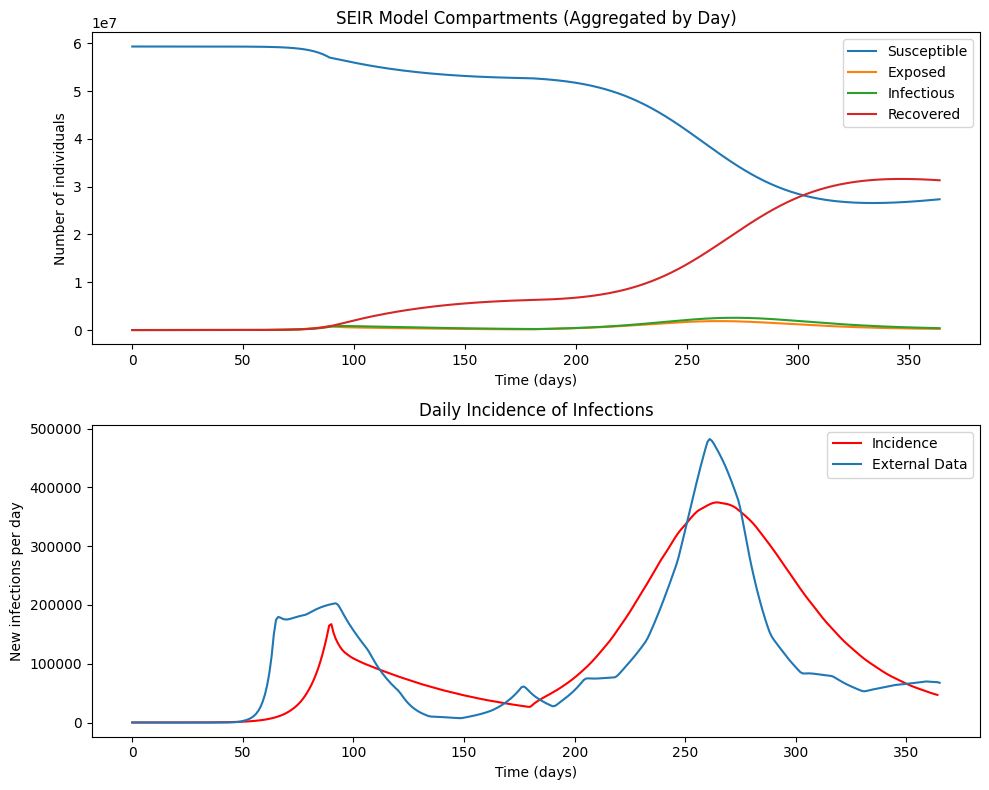

In [45]:
# -------------------------------------------------------- #
# 3. Demo SEIR
# -------------------------------------------------------- #

n_age = 17

# Read in contact matrix and age distribution
contact_matrix = pd.read_csv("data/seir_contact_matrix.csv").values
N = pd.read_csv("data/sa_ages.csv").n.values

latent_period = 5.0
infectious_period = 7.0
immunity_period = 365

I0 = 20

Rt = [3.0, 0.9, 1.8]
tt_Rt = [0, 90, 180]

model = SEIR(contact_matrix, latent_period, infectious_period, immunity_period, N, I0, seed=42)
model.run(t_end=365, Rt=Rt, tt_Rt=tt_Rt, dt=0.1)

axs = model.plot_output(show = False)

dat = pd.read_csv(
    "https://raw.githubusercontent.com/mrc-ide/global-lmic-reports/refs/heads/main/ZAF/2022-06-20/projections.csv"
)
dat["date"] = pd.to_datetime(dat["date"])
dat["t"] = (dat["date"] - dat["date"].min()).dt.days
dat["t"] = dat["t"].astype(int)

axs[1].plot(
    dat.loc[(dat["compartment"] == "infections") 
            & (dat["scenario"] == "Maintain Status Quo") 
            & (dat["t"] >= 110) 
            & (dat["t"] <= 365 + 110), "t"] - 110,
    dat.loc[(dat["compartment"] == "infections") 
            & (dat["scenario"] == "Maintain Status Quo") 
            & (dat["t"] >= 110) 
            & (dat["t"] <= 365 + 110), "y_median"],
    label='External Data'
)
axs[1].legend()
plt.show()

## 4. Latin Hypercube Sampling (LHS) for Parameter Exploration

Latin Hypercube Sampling (LHS) is a statistical method that efficiently explores a high-dimensional parameter space. In our model, we sample parameters such as the latent period, infectious period, immunity duration, reproduction numbers, and switching times. 

This approach helps us generate diverse simulation runs so that the surrogate model can be trained on a wide range of scenarios.

Sample 1:
Parameters:
{'latent_period': 3.2904175805776146, 'infectious_period': 6.736672936148769, 'immunity_period': 547.5, 'Rt': [0.9936844614020072, 3.939726497351905, 0.8156016949524763], 'tt_Rt': [57.16580894028941, 86.41807084169139, 166.15659101973364]}
Total incidence on final day: 6.54545146971941e-07
--------------------------------------------------
Sample 2:
Parameters:
{'latent_period': 2.619845624841773, 'infectious_period': 5.577521185460451, 'immunity_period': 547.5, 'Rt': [2.307926323148375, 2.8334325675066685, 1.796214912750508], 'tt_Rt': [63.36245638952496, 108.08548231687473, 193.1828383464567]}
Total incidence on final day: 0.06283551902743056
--------------------------------------------------
Sample 3:
Parameters:
{'latent_period': 3.668947531202967, 'infectious_period': 6.021001360526761, 'immunity_period': 547.5, 'Rt': [3.7731033803968845, 2.0987532643872617, 2.1484024823537937], 'tt_Rt': [86.64849508778714, 125.99836988818898, 194.16083876444097]}
Total incide

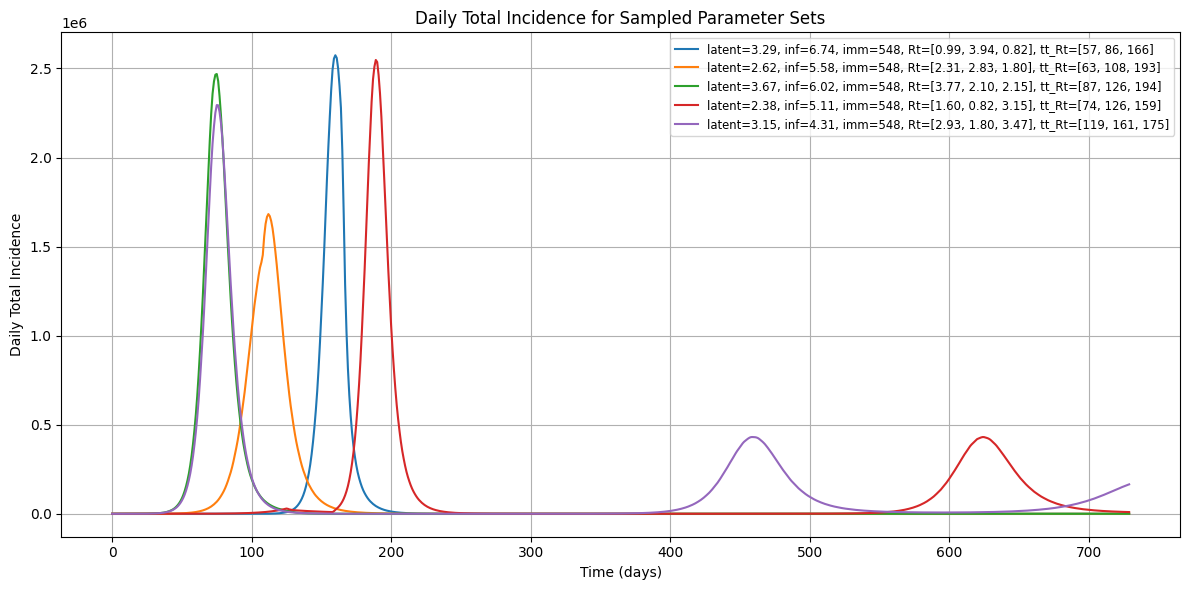

In [46]:
# -------------------------------------------------------- #
# 4. LHS
# -------------------------------------------------------- #

from scipy.stats import qmc

def sample_parameter_sets(
    n_samples, latent_range, infectious_range, immunity_range, Rt_range, tt_Rt_range, seed=None
):
    """
    Sample parameter sets using Latin Hypercube Sampling.
    """
    n_params = 9
    sampler = qmc.LatinHypercube(d=n_params, seed=seed)
    sample_unit = sampler.random(n=n_samples)

    latent_samples = latent_range[0] + sample_unit[:, 0] * (latent_range[1] - latent_range[0])
    infectious_samples = infectious_range[0] + sample_unit[:, 1] * (infectious_range[1] - infectious_range[0])
    immunity_samples = immunity_range[0] + sample_unit[:, 2] * (immunity_range[1] - immunity_range[0])

    Rt_samples = []
    for i in range(3):
        col = 3 + i
        Rt_samples.append(Rt_range[0] + sample_unit[:, col] * (Rt_range[1] - Rt_range[0]))
    Rt_samples = np.column_stack(Rt_samples)

    tt_Rt_samples = []
    for i in range(3):
        col = 6 + i
        tt_Rt_samples.append(tt_Rt_range[0] + sample_unit[:, col] * (tt_Rt_range[1] - tt_Rt_range[0]))
    tt_Rt_samples = np.column_stack(tt_Rt_samples)

    parameter_sets = []
    for i in range(n_samples):
        params = {
            "latent_period": latent_samples[i],
            "infectious_period": infectious_samples[i],
            "immunity_period": immunity_samples[i],
            "Rt": list(Rt_samples[i, :]),
            "tt_Rt": sorted(list(tt_Rt_samples[i, :]))
        }
        parameter_sets.append(params)

    return parameter_sets

def sample_and_run_models(
    n_samples,
    contact_matrix,
    N,
    I0,
    t_end,
    latent_range,
    infectious_range,
    immunity_range,
    Rt_range,
    tt_Rt_range,
    dt=0.1,
    seed=None,
):
    """
    Sample parameter sets using LHS and run the SEIR model for each set.
    """
    parameter_sets = sample_parameter_sets(
        n_samples, latent_range, infectious_range, immunity_range, Rt_range, tt_Rt_range, seed=seed
    )

    results = []
    for params in parameter_sets:
        model = SEIR(
            contact_matrix,
            params["latent_period"],
            params["infectious_period"],
            params["immunity_period"],
            N,
            I0,
            seed=seed,
        )
        model.run(t_end=t_end, Rt=params["Rt"], tt_Rt=params["tt_Rt"], dt=dt)
        output = model.get_output()
        results.append((params, output))

    return results

def plot_sampled_results(sampled_results):
    """
    Plot the simulation outputs for multiple sampled runs.
    """
    plt.figure(figsize=(12, 6))

    for i, (params, output) in enumerate(sampled_results):
        t = output["time"]
        total_incidence = output["total_incidence"]
        label_str = (
            f"latent={params['latent_period']:.2f}, "
            f"inf={params['infectious_period']:.2f}, "
            f"imm={params['immunity_period']:.0f}, "
            f"Rt=[{params['Rt'][0]:.2f}, {params['Rt'][1]:.2f}, {params['Rt'][2]:.2f}], "
            f"tt_Rt=[{params['tt_Rt'][0]:.0f}, {params['tt_Rt'][1]:.0f}, {params['tt_Rt'][2]:.0f}]"
        )
        plt.plot(t, total_incidence, label=label_str)

    plt.xlabel("Time (days)")
    plt.ylabel("Daily Total Incidence")
    plt.title("Daily Total Incidence for Sampled Parameter Sets")
    plt.legend(fontsize="small", loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# LHS Demo

latent_range = (2.0, 4.0)
infectious_range = (4.0, 7.0)
immunity_range = (365*1.5, 365*1.5)
Rt_range = (0.8, 4.0)
tt_Rt_range = (50, 200)

n_samples = 5

sampled_results = sample_and_run_models(
    n_samples,
    contact_matrix,
    N,
    I0,
    t_end=730,
    latent_range=latent_range,
    infectious_range=infectious_range,
    immunity_range=immunity_range,
    Rt_range=Rt_range,
    tt_Rt_range=tt_Rt_range,
    dt=0.1,
    seed=42,
)

for i, (params, output) in enumerate(sampled_results):
    print(f"Sample {i+1}:")
    print("Parameters:")
    print(params)
    print("Total incidence on final day:", output["total_incidence"][-1])
    print("-" * 50)

plot_sampled_results(sampled_results)

## 5. Surrogate Training with LSTM and GRU

In the final section we build surrogate models to emulate the output of the SEIR simulation. 

### Dataset and Scaling

We first construct a custom PyTorch dataset that for each simulation run produces an input sequence `X` of shape `(T, 1+9)`:

- The **first column** is a normalized time feature (values between 0 and 1).
- The **remaining columns** are the simulation parameters (latent period, infectious period, immunity period, Rt values, and switching times) repeated over all time steps. 

The target `Y` is the time series of total incidence (per day). Both inputs and targets are scaled using `StandardScaler`.

### LSTM and GRU Models

We define two architectures:

- **LSTM Model:** Uses LSTM cells as described earlier.
- **GRU Model:** Uses GRU cells.

The surrogate learns to predict the output sequence from the input sequence. During training, the model minimizes the mean-squared error (MSE) between its predictions and the true simulation output.

Below is the code for the dataset definition, model definitions, training loop, and prediction plotting. 

The training process uses mixed precision (via `torch.cuda.amp`) for efficiency and includes learning rate scheduling.

In [47]:
# -------------------------------------------------------- #
# 6. DLS Surrogate Training
# -------------------------------------------------------- #

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import time
import random
import math
from sklearn.preprocessing import StandardScaler

t_end = 400
train_results = sample_and_run_models(2000, contact_matrix, N, I0, t_end, latent_range, infectious_range, immunity_range,
                                            Rt_range, tt_Rt_range, dt=0.1, seed=42)
test_results = sample_and_run_models(200, contact_matrix, N, I0, t_end,
                                            latent_range, infectious_range, immunity_range,
                                              Rt_range, tt_Rt_range, dt=0.1, seed=42)

##############################################################################
# 0. Dataset Definition with Data Scaling
##############################################################################

class SEIRTimeSeriesDataset(Dataset):
    """
    Expects a list of tuples (params, output). For each sample, creates an input sequence X of shape (T, 10) where:
      - Column 0: normalized time feature (values between 0 and 1)
      - Columns 1-10: 9-dimensional parameter vector repeated at each time step
    The target Y is the total incidence time series (reshaped to (T, 1)).
    """

    def __init__(self, results_list, x_scaler=None, y_scaler=None):
        self.samples = []
        self.seq_len = None
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        for params, output in results_list:
            p = np.array([
                params["latent_period"],
                params["infectious_period"],
                params["immunity_period"]
            ] + params["Rt"] + params["tt_Rt"], dtype=np.float32)
            y = np.array(output["total_incidence"], dtype=np.float32)
            if self.seq_len is None:
                self.seq_len = len(y)
            else:
                assert len(y) == self.seq_len, "All sequences must have the same length."
            self.samples.append((p, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        T = self.seq_len
        time_feature = np.linspace(0, 1, T).reshape(T, 1).astype(np.float32)
        p_repeated = np.tile(p, (T, 1))
        X = np.concatenate([time_feature, p_repeated], axis=1)
        if self.x_scaler is not None:
            scaled_params = self.x_scaler.transform(p.reshape(1, -1))
            scaled_params = np.tile(scaled_params, (T, 1))
            X[:, 1:] = scaled_params
        if self.y_scaler is not None:
            y = self.y_scaler.transform(y.reshape(-1, 1)).reshape(-1)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

##############################################################################
# 1. Model Definitions: LSTM and GRU
##############################################################################

class SEIRLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.1):
        super(SEIRLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.ln(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

class SEIRGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.1):
        super(SEIRGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.ln(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

##############################################################################
# 2. Training Function
##############################################################################

def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, device):
    criterion = nn.MSELoss()
    scaler = GradScaler()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        epoch_start = time.time()

        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            with autocast():
                pred = model(X)
                loss = criterion(pred, Y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f} | Duration: {time.time()-epoch_start:.2f}s")

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                with autocast():
                    pred_val = model(X_val)
                    loss_val = criterion(pred_val, Y_val)
                total_val_loss += loss_val.item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"          Val Loss   = {avg_val_loss:.4f}")

        if scheduler is not None:
            scheduler.step(avg_train_loss)

##############################################################################
# 3. Prediction Plotting Function (Side by Side for LSTM and GRU)
##############################################################################

def plot_predictions(model_lstm, model_gru, dataset, device, y_scaler, n_samples=5):
    model_lstm.eval()
    model_gru.eval()
    indices = np.random.choice(len(dataset), n_samples, replace=False)

    n_cols = 5
    n_rows = math.ceil(n_samples / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    if n_rows * n_cols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for ax in axs[n_samples:]:
        ax.axis("off")

    for i, idx in enumerate(indices):
        X, Y = dataset[idx]
        X = X.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_lstm = model_lstm(X)
            pred_gru = model_gru(X)

        pred_lstm = pred_lstm.squeeze(0).cpu().numpy()
        pred_gru = pred_gru.squeeze(0).cpu().numpy()
        Y = Y.squeeze(1).cpu().numpy()

        pred_lstm_orig = y_scaler.inverse_transform(pred_lstm)
        pred_gru_orig = y_scaler.inverse_transform(pred_gru)
        Y_orig = y_scaler.inverse_transform(Y.reshape(-1, 1)).reshape(-1)

        ax = axs[i]
        ax.plot(Y_orig, label="Ground Truth", color="black")
        ax.plot(pred_lstm_orig, label="LSTM", linestyle="--", color="blue")
        ax.plot(pred_gru_orig, label="GRU", linestyle=":", color="red")
        ax.set_title(f"Sample {idx}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Total Incidence")
        ax.legend()

    plt.tight_layout()
    plt.show()

##############################################################################
# 5. Main Script for Surrogate Training
##############################################################################

train_params = np.array([
    np.array([
        p["latent_period"], p["infectious_period"], p["immunity_period"]
    ] + p["Rt"] + p["tt_Rt"])
    for (p, o) in train_results
], dtype=np.float32)

x_scaler = StandardScaler().fit(train_params)

train_targets = np.array([
    o["total_incidence"] for (p, o) in train_results
], dtype=np.float32)
y_scaler = StandardScaler().fit(train_targets.reshape(-1, 1))

train_dataset = SEIRTimeSeriesDataset(train_results, x_scaler=x_scaler, y_scaler=y_scaler)
val_dataset = SEIRTimeSeriesDataset(test_results, x_scaler=x_scaler, y_scaler=y_scaler)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 10  
hidden_size = 128
output_size = 1
num_layers = 2
dropout_prob = 0.05

# Create both LSTM and GRU models
model_lstm = SEIRLSTMModel(input_size, hidden_size, output_size, num_layers, dropout_prob).to(device)
model_gru = SEIRGRUModel(input_size, hidden_size, output_size, num_layers, dropout_prob).to(device)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-3)
scheduler_lstm = optim.lr_scheduler.StepLR(optimizer_lstm, step_size=10, gamma=0.5)

optimizer_gru = optim.Adam(model_gru.parameters(), lr=1e-3)
scheduler_gru = optim.lr_scheduler.StepLR(optimizer_gru, step_size=10, gamma=0.5)

epochs = 300
print("Training LSTM model...")
train_model(model_lstm, train_loader, val_loader, epochs, optimizer_lstm, scheduler_lstm, device)
print("Training GRU model...")
train_model(model_gru, train_loader, val_loader, epochs, optimizer_gru, scheduler_gru, device)




Training LSTM model...
Epoch 1: Train Loss = 1.2004 | Duration: 0.60s
          Val Loss   = 1.0327


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2: Train Loss = 1.0271 | Duration: 0.47s
          Val Loss   = 1.0387


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3: Train Loss = 0.9966 | Duration: 0.48s
          Val Loss   = 0.9890


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4: Train Loss = 0.9740 | Duration: 0.47s
          Val Loss   = 0.9820


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss = 0.9613 | Duration: 0.47s
          Val Loss   = 0.9707


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6: Train Loss = 0.9499 | Duration: 0.47s
          Val Loss   = 0.9646


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7: Train Loss = 0.9443 | Duration: 0.46s
          Val Loss   = 0.9584


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8: Train Loss = 0.9380 | Duration: 0.46s
          Val Loss   = 0.9548


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9: Train Loss = 0.9332 | Duration: 0.46s
          Val Loss   = 0.9525


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10: Train Loss = 0.9292 | Duration: 0.45s
          Val Loss   = 0.9496


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 11: Train Loss = 0.9253 | Duration: 0.46s
          Val Loss   = 0.9442


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 12: Train Loss = 0.9146 | Duration: 0.47s
          Val Loss   = 0.9307


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 13: Train Loss = 0.9493 | Duration: 0.48s
          Val Loss   = 0.9842


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 14: Train Loss = 0.9624 | Duration: 0.46s
          Val Loss   = 0.9754


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 15: Train Loss = 0.9417 | Duration: 0.47s
          Val Loss   = 0.9543


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 16: Train Loss = 0.9241 | Duration: 0.47s
          Val Loss   = 0.9460


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 17: Train Loss = 0.9195 | Duration: 0.45s
          Val Loss   = 0.9407


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 18: Train Loss = 0.9125 | Duration: 0.48s
          Val Loss   = 0.9335


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 19: Train Loss = 0.9039 | Duration: 0.46s
          Val Loss   = 0.9174


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 20: Train Loss = 0.8854 | Duration: 0.46s
          Val Loss   = 0.9116


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 21: Train Loss = 0.8629 | Duration: 0.46s
          Val Loss   = 0.8494


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 22: Train Loss = 0.8347 | Duration: 0.46s
          Val Loss   = 0.8441


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 23: Train Loss = 0.7678 | Duration: 0.46s
          Val Loss   = 0.7475


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 24: Train Loss = 0.7114 | Duration: 0.48s
          Val Loss   = 0.6341


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 25: Train Loss = 0.6390 | Duration: 0.46s
          Val Loss   = 0.8318


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 26: Train Loss = 0.6807 | Duration: 0.45s
          Val Loss   = 0.6771


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 27: Train Loss = 0.5802 | Duration: 0.45s
          Val Loss   = 0.5105


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 28: Train Loss = 0.4227 | Duration: 0.46s
          Val Loss   = 0.4929


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 29: Train Loss = 0.4127 | Duration: 0.49s
          Val Loss   = 0.4616


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 30: Train Loss = 0.3375 | Duration: 0.45s
          Val Loss   = 0.3174


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 31: Train Loss = 0.2928 | Duration: 0.46s
          Val Loss   = 0.3329


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 32: Train Loss = 0.2598 | Duration: 0.45s
          Val Loss   = 0.3117


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 33: Train Loss = 0.2352 | Duration: 0.46s
          Val Loss   = 0.2570


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 34: Train Loss = 0.1916 | Duration: 0.45s
          Val Loss   = 0.1984


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 35: Train Loss = 0.1926 | Duration: 0.45s
          Val Loss   = 0.2328


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 36: Train Loss = 0.1954 | Duration: 0.45s
          Val Loss   = 0.1782


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 37: Train Loss = 0.1565 | Duration: 0.45s
          Val Loss   = 0.1573


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 38: Train Loss = 0.1545 | Duration: 0.45s
          Val Loss   = 0.2294


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 39: Train Loss = 0.1552 | Duration: 0.46s
          Val Loss   = 0.1659


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 40: Train Loss = 0.1465 | Duration: 0.45s
          Val Loss   = 0.1543


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 41: Train Loss = 0.1524 | Duration: 0.46s
          Val Loss   = 0.1796


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 42: Train Loss = 0.1448 | Duration: 0.46s
          Val Loss   = 0.1513


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 43: Train Loss = 0.1238 | Duration: 0.49s
          Val Loss   = 0.1342


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 44: Train Loss = 0.1301 | Duration: 0.46s
          Val Loss   = 0.1345


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 45: Train Loss = 0.1252 | Duration: 0.46s
          Val Loss   = 0.1432


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 46: Train Loss = 0.1185 | Duration: 0.46s
          Val Loss   = 0.1697


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 47: Train Loss = 0.1210 | Duration: 0.46s
          Val Loss   = 0.1408


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 48: Train Loss = 0.1050 | Duration: 0.46s
          Val Loss   = 0.1291


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 49: Train Loss = 0.1271 | Duration: 0.45s
          Val Loss   = 0.1516


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 50: Train Loss = 0.1145 | Duration: 0.47s
          Val Loss   = 0.1071


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 51: Train Loss = 0.0991 | Duration: 0.45s
          Val Loss   = 0.1231


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 52: Train Loss = 0.0947 | Duration: 0.45s
          Val Loss   = 0.1269


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 53: Train Loss = 0.0927 | Duration: 0.45s
          Val Loss   = 0.0997


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 54: Train Loss = 0.0852 | Duration: 0.45s
          Val Loss   = 0.0988


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 55: Train Loss = 0.0758 | Duration: 0.44s
          Val Loss   = 0.0994


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 56: Train Loss = 0.0908 | Duration: 0.45s
          Val Loss   = 0.1189


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 57: Train Loss = 0.0882 | Duration: 0.45s
          Val Loss   = 0.1136


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 58: Train Loss = 0.0729 | Duration: 0.44s
          Val Loss   = 0.1133


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 59: Train Loss = 0.0810 | Duration: 0.44s
          Val Loss   = 0.0886


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 60: Train Loss = 0.0873 | Duration: 0.45s
          Val Loss   = 0.0963


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 61: Train Loss = 0.0818 | Duration: 0.46s
          Val Loss   = 0.0873


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 62: Train Loss = 0.0765 | Duration: 0.44s
          Val Loss   = 0.0916


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 63: Train Loss = 0.0673 | Duration: 0.44s
          Val Loss   = 0.0951


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 64: Train Loss = 0.0700 | Duration: 0.48s
          Val Loss   = 0.0762


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 65: Train Loss = 0.0652 | Duration: 0.46s
          Val Loss   = 0.0791


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 66: Train Loss = 0.0812 | Duration: 0.45s
          Val Loss   = 0.0978


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 67: Train Loss = 0.0991 | Duration: 0.49s
          Val Loss   = 0.1202


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 68: Train Loss = 0.0867 | Duration: 0.45s
          Val Loss   = 0.0837


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 69: Train Loss = 0.0769 | Duration: 0.44s
          Val Loss   = 0.0735


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 70: Train Loss = 0.0774 | Duration: 0.44s
          Val Loss   = 0.0885


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 71: Train Loss = 0.0646 | Duration: 0.54s
          Val Loss   = 0.0621


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 72: Train Loss = 0.0556 | Duration: 0.56s
          Val Loss   = 0.0536


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 73: Train Loss = 0.0463 | Duration: 0.79s
          Val Loss   = 0.0540


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 74: Train Loss = 0.0463 | Duration: 0.59s
          Val Loss   = 0.0434


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 75: Train Loss = 0.0411 | Duration: 0.49s
          Val Loss   = 0.0461


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 76: Train Loss = 0.0399 | Duration: 0.48s
          Val Loss   = 0.0466


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 77: Train Loss = 0.0563 | Duration: 0.47s
          Val Loss   = 0.1090


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 78: Train Loss = 0.0794 | Duration: 0.47s
          Val Loss   = 0.1049


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 79: Train Loss = 0.0630 | Duration: 0.48s
          Val Loss   = 0.0680


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 80: Train Loss = 0.0580 | Duration: 0.54s
          Val Loss   = 0.0957


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 81: Train Loss = 0.0577 | Duration: 0.52s
          Val Loss   = 0.0575


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 82: Train Loss = 0.0475 | Duration: 0.48s
          Val Loss   = 0.0404


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 83: Train Loss = 0.0427 | Duration: 0.47s
          Val Loss   = 0.0432


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 84: Train Loss = 0.0432 | Duration: 0.47s
          Val Loss   = 0.0432


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 85: Train Loss = 0.0425 | Duration: 0.47s
          Val Loss   = 0.0411


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 86: Train Loss = 0.0522 | Duration: 0.47s
          Val Loss   = 0.0837


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 87: Train Loss = 0.0618 | Duration: 0.47s
          Val Loss   = 0.0817


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 88: Train Loss = 0.0513 | Duration: 0.47s
          Val Loss   = 0.0460


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 89: Train Loss = 0.0439 | Duration: 0.48s
          Val Loss   = 0.0416


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 90: Train Loss = 0.0403 | Duration: 0.47s
          Val Loss   = 0.0409


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 91: Train Loss = 0.0351 | Duration: 0.47s
          Val Loss   = 0.0365


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 92: Train Loss = 0.0339 | Duration: 0.48s
          Val Loss   = 0.0459


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 93: Train Loss = 0.0462 | Duration: 0.48s
          Val Loss   = 0.0475


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 94: Train Loss = 0.0505 | Duration: 0.47s
          Val Loss   = 0.0399


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 95: Train Loss = 0.0481 | Duration: 0.48s
          Val Loss   = 0.0496


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 96: Train Loss = 0.0391 | Duration: 0.47s
          Val Loss   = 0.0369


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 97: Train Loss = 0.0370 | Duration: 0.48s
          Val Loss   = 0.0333


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 98: Train Loss = 0.0325 | Duration: 0.47s
          Val Loss   = 0.0387


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 99: Train Loss = 0.0329 | Duration: 0.48s
          Val Loss   = 0.0322


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 100: Train Loss = 0.0301 | Duration: 0.48s
          Val Loss   = 0.0316


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 101: Train Loss = 0.0314 | Duration: 0.47s
          Val Loss   = 0.0343


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 102: Train Loss = 0.0330 | Duration: 0.48s
          Val Loss   = 0.0324


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 103: Train Loss = 0.0316 | Duration: 0.48s
          Val Loss   = 0.0271


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 104: Train Loss = 0.0297 | Duration: 0.48s
          Val Loss   = 0.0332


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 105: Train Loss = 0.0301 | Duration: 0.48s
          Val Loss   = 0.0314


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 106: Train Loss = 0.0268 | Duration: 0.49s
          Val Loss   = 0.0305


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 107: Train Loss = 0.0265 | Duration: 0.48s
          Val Loss   = 0.0331


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 108: Train Loss = 0.0286 | Duration: 0.50s
          Val Loss   = 0.0285


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 109: Train Loss = 0.0262 | Duration: 0.47s
          Val Loss   = 0.0286


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 110: Train Loss = 0.0280 | Duration: 0.48s
          Val Loss   = 0.0262


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 111: Train Loss = 0.0264 | Duration: 0.47s
          Val Loss   = 0.0254


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 112: Train Loss = 0.0303 | Duration: 0.48s
          Val Loss   = 0.0349


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 113: Train Loss = 0.0276 | Duration: 0.49s
          Val Loss   = 0.0257


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 114: Train Loss = 0.0251 | Duration: 0.48s
          Val Loss   = 0.0255


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 115: Train Loss = 0.0239 | Duration: 0.50s
          Val Loss   = 0.0269


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 116: Train Loss = 0.0244 | Duration: 0.48s
          Val Loss   = 0.0286


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 117: Train Loss = 0.0279 | Duration: 0.50s
          Val Loss   = 0.0337


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 118: Train Loss = 0.0325 | Duration: 0.48s
          Val Loss   = 0.0274


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 119: Train Loss = 0.0405 | Duration: 0.47s
          Val Loss   = 0.0588


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 120: Train Loss = 0.0428 | Duration: 0.48s
          Val Loss   = 0.0444


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 121: Train Loss = 0.0348 | Duration: 0.47s
          Val Loss   = 0.0316


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 122: Train Loss = 0.0318 | Duration: 0.49s
          Val Loss   = 0.0389


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 123: Train Loss = 0.0305 | Duration: 0.49s
          Val Loss   = 0.0328


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 124: Train Loss = 0.0402 | Duration: 0.47s
          Val Loss   = 0.0493


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 125: Train Loss = 0.0356 | Duration: 0.47s
          Val Loss   = 0.0377


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 126: Train Loss = 0.0309 | Duration: 0.49s
          Val Loss   = 0.0346


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 127: Train Loss = 0.0263 | Duration: 0.47s
          Val Loss   = 0.0322


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 128: Train Loss = 0.0271 | Duration: 0.51s
          Val Loss   = 0.0402


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 129: Train Loss = 0.0264 | Duration: 0.47s
          Val Loss   = 0.0246


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 130: Train Loss = 0.0247 | Duration: 0.48s
          Val Loss   = 0.0283


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 131: Train Loss = 0.0282 | Duration: 0.47s
          Val Loss   = 0.0364


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 132: Train Loss = 0.0353 | Duration: 0.48s
          Val Loss   = 0.0357


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 133: Train Loss = 0.0288 | Duration: 0.49s
          Val Loss   = 0.0280


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 134: Train Loss = 0.0223 | Duration: 0.48s
          Val Loss   = 0.0330


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 135: Train Loss = 0.0249 | Duration: 0.47s
          Val Loss   = 0.0296


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 136: Train Loss = 0.0238 | Duration: 0.48s
          Val Loss   = 0.0271


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 137: Train Loss = 0.0279 | Duration: 0.48s
          Val Loss   = 0.0327


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 138: Train Loss = 0.0346 | Duration: 0.48s
          Val Loss   = 0.0329


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 139: Train Loss = 0.0249 | Duration: 0.53s
          Val Loss   = 0.0219


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 140: Train Loss = 0.0264 | Duration: 0.49s
          Val Loss   = 0.0335


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 141: Train Loss = 0.0391 | Duration: 0.48s
          Val Loss   = 0.0314


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 142: Train Loss = 0.0311 | Duration: 0.48s
          Val Loss   = 0.0335


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 143: Train Loss = 0.0380 | Duration: 0.47s
          Val Loss   = 0.0474


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 144: Train Loss = 0.0387 | Duration: 0.47s
          Val Loss   = 0.0678


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 145: Train Loss = 0.0503 | Duration: 0.50s
          Val Loss   = 0.0683


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 146: Train Loss = 0.0429 | Duration: 0.48s
          Val Loss   = 0.0386


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 147: Train Loss = 0.0359 | Duration: 0.50s
          Val Loss   = 0.0439


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 148: Train Loss = 0.0399 | Duration: 0.47s
          Val Loss   = 0.0419


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 149: Train Loss = 0.0315 | Duration: 0.47s
          Val Loss   = 0.0258


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 150: Train Loss = 0.0284 | Duration: 0.49s
          Val Loss   = 0.0347


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 151: Train Loss = 0.0378 | Duration: 0.47s
          Val Loss   = 0.0389


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 152: Train Loss = 0.0311 | Duration: 0.47s
          Val Loss   = 0.0459


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 153: Train Loss = 0.0301 | Duration: 0.47s
          Val Loss   = 0.0320


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 154: Train Loss = 0.0291 | Duration: 0.47s
          Val Loss   = 0.0418


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 155: Train Loss = 0.0332 | Duration: 0.47s
          Val Loss   = 0.0266


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 156: Train Loss = 0.0254 | Duration: 0.47s
          Val Loss   = 0.0425


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 157: Train Loss = 0.0238 | Duration: 0.47s
          Val Loss   = 0.0242


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 158: Train Loss = 0.0218 | Duration: 0.47s
          Val Loss   = 0.0219


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 159: Train Loss = 0.0196 | Duration: 0.47s
          Val Loss   = 0.0216


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 160: Train Loss = 0.0188 | Duration: 0.47s
          Val Loss   = 0.0223


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 161: Train Loss = 0.0182 | Duration: 0.50s
          Val Loss   = 0.0217


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 162: Train Loss = 0.0198 | Duration: 0.47s
          Val Loss   = 0.0212


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 163: Train Loss = 0.0209 | Duration: 0.47s
          Val Loss   = 0.0260


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 164: Train Loss = 0.0209 | Duration: 0.47s
          Val Loss   = 0.0231


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 165: Train Loss = 0.0212 | Duration: 0.49s
          Val Loss   = 0.0185


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 166: Train Loss = 0.0195 | Duration: 0.47s
          Val Loss   = 0.0224


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 167: Train Loss = 0.0196 | Duration: 0.47s
          Val Loss   = 0.0225


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 168: Train Loss = 0.0169 | Duration: 0.47s
          Val Loss   = 0.0243


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 169: Train Loss = 0.0159 | Duration: 0.47s
          Val Loss   = 0.0186


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 170: Train Loss = 0.0179 | Duration: 0.47s
          Val Loss   = 0.0185


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 171: Train Loss = 0.0200 | Duration: 0.47s
          Val Loss   = 0.0232


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 172: Train Loss = 0.0217 | Duration: 0.48s
          Val Loss   = 0.0238


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 173: Train Loss = 0.0264 | Duration: 0.49s
          Val Loss   = 0.0342


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 174: Train Loss = 0.0300 | Duration: 0.47s
          Val Loss   = 0.0344


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 175: Train Loss = 0.0203 | Duration: 0.48s
          Val Loss   = 0.0213


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 176: Train Loss = 0.0212 | Duration: 0.47s
          Val Loss   = 0.0314


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 177: Train Loss = 0.0240 | Duration: 0.48s
          Val Loss   = 0.0417


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 178: Train Loss = 0.0207 | Duration: 0.48s
          Val Loss   = 0.0208


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 179: Train Loss = 0.0163 | Duration: 0.47s
          Val Loss   = 0.0210


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 180: Train Loss = 0.0181 | Duration: 0.48s
          Val Loss   = 0.0295


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 181: Train Loss = 0.0229 | Duration: 0.49s
          Val Loss   = 0.0209


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 182: Train Loss = 0.0213 | Duration: 0.48s
          Val Loss   = 0.0184


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 183: Train Loss = 0.0191 | Duration: 0.47s
          Val Loss   = 0.0321


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 184: Train Loss = 0.0310 | Duration: 0.47s
          Val Loss   = 0.0401


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 185: Train Loss = 0.0303 | Duration: 0.47s
          Val Loss   = 0.0344


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 186: Train Loss = 0.0230 | Duration: 0.47s
          Val Loss   = 0.0223


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 187: Train Loss = 0.0229 | Duration: 0.48s
          Val Loss   = 0.0257


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 188: Train Loss = 0.0239 | Duration: 0.48s
          Val Loss   = 0.0342


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 189: Train Loss = 0.0258 | Duration: 0.48s
          Val Loss   = 0.0265


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 190: Train Loss = 0.0211 | Duration: 0.49s
          Val Loss   = 0.0246


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 191: Train Loss = 0.0193 | Duration: 0.47s
          Val Loss   = 0.0254


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 192: Train Loss = 0.0204 | Duration: 0.47s
          Val Loss   = 0.0195


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 193: Train Loss = 0.0160 | Duration: 0.47s
          Val Loss   = 0.0182


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 194: Train Loss = 0.0178 | Duration: 0.51s
          Val Loss   = 0.0300


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 195: Train Loss = 0.0217 | Duration: 0.48s
          Val Loss   = 0.0232


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 196: Train Loss = 0.0171 | Duration: 0.52s
          Val Loss   = 0.0263


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 197: Train Loss = 0.0170 | Duration: 0.47s
          Val Loss   = 0.0246


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 198: Train Loss = 0.0144 | Duration: 0.47s
          Val Loss   = 0.0156


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 199: Train Loss = 0.0137 | Duration: 0.48s
          Val Loss   = 0.0185


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 200: Train Loss = 0.0147 | Duration: 0.48s
          Val Loss   = 0.0181


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 201: Train Loss = 0.0135 | Duration: 0.47s
          Val Loss   = 0.0224


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 202: Train Loss = 0.0168 | Duration: 0.51s
          Val Loss   = 0.0211


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 203: Train Loss = 0.0164 | Duration: 0.49s
          Val Loss   = 0.0286


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 204: Train Loss = 0.0251 | Duration: 0.50s
          Val Loss   = 0.0305


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 205: Train Loss = 0.0219 | Duration: 0.47s
          Val Loss   = 0.0310


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 206: Train Loss = 0.0205 | Duration: 0.47s
          Val Loss   = 0.0220


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 207: Train Loss = 0.0238 | Duration: 0.47s
          Val Loss   = 0.0263


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 208: Train Loss = 0.0261 | Duration: 0.47s
          Val Loss   = 0.0374


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 209: Train Loss = 0.0272 | Duration: 0.47s
          Val Loss   = 0.0247


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 210: Train Loss = 0.0197 | Duration: 0.47s
          Val Loss   = 0.0200


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 211: Train Loss = 0.0184 | Duration: 0.47s
          Val Loss   = 0.0199


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 212: Train Loss = 0.0167 | Duration: 0.49s
          Val Loss   = 0.0209


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 213: Train Loss = 0.0156 | Duration: 0.47s
          Val Loss   = 0.0212


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 214: Train Loss = 0.0186 | Duration: 0.47s
          Val Loss   = 0.0317


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 215: Train Loss = 0.0172 | Duration: 0.47s
          Val Loss   = 0.0192


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 216: Train Loss = 0.0163 | Duration: 0.47s
          Val Loss   = 0.0224


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 217: Train Loss = 0.0136 | Duration: 0.47s
          Val Loss   = 0.0125


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 218: Train Loss = 0.0121 | Duration: 0.47s
          Val Loss   = 0.0223


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 219: Train Loss = 0.0177 | Duration: 0.47s
          Val Loss   = 0.0212


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 220: Train Loss = 0.0190 | Duration: 0.47s
          Val Loss   = 0.0263


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 221: Train Loss = 0.0234 | Duration: 0.47s
          Val Loss   = 0.0222


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 222: Train Loss = 0.0233 | Duration: 0.52s
          Val Loss   = 0.0501


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 223: Train Loss = 0.0281 | Duration: 0.49s
          Val Loss   = 0.0274


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 224: Train Loss = 0.0277 | Duration: 0.48s
          Val Loss   = 0.0420


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 225: Train Loss = 0.0238 | Duration: 0.48s
          Val Loss   = 0.0300


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 226: Train Loss = 0.0282 | Duration: 0.47s
          Val Loss   = 0.0457


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 227: Train Loss = 0.0296 | Duration: 0.47s
          Val Loss   = 0.0172


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 228: Train Loss = 0.0225 | Duration: 0.48s
          Val Loss   = 0.0360


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 229: Train Loss = 0.0302 | Duration: 0.47s
          Val Loss   = 0.0315


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 230: Train Loss = 0.0294 | Duration: 0.47s
          Val Loss   = 0.0383


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 231: Train Loss = 0.0272 | Duration: 0.47s
          Val Loss   = 0.0237


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 232: Train Loss = 0.0208 | Duration: 0.48s
          Val Loss   = 0.0181


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 233: Train Loss = 0.0153 | Duration: 0.47s
          Val Loss   = 0.0171


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 234: Train Loss = 0.0134 | Duration: 0.47s
          Val Loss   = 0.0170


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 235: Train Loss = 0.0133 | Duration: 0.47s
          Val Loss   = 0.0183


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 236: Train Loss = 0.0125 | Duration: 0.47s
          Val Loss   = 0.0139


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 237: Train Loss = 0.0136 | Duration: 0.47s
          Val Loss   = 0.0166


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 238: Train Loss = 0.0175 | Duration: 0.47s
          Val Loss   = 0.0186


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 239: Train Loss = 0.0197 | Duration: 0.48s
          Val Loss   = 0.0213


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 240: Train Loss = 0.0217 | Duration: 0.48s
          Val Loss   = 0.0194


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 241: Train Loss = 0.0176 | Duration: 0.48s
          Val Loss   = 0.0184


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 242: Train Loss = 0.0133 | Duration: 0.50s
          Val Loss   = 0.0139


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 243: Train Loss = 0.0114 | Duration: 0.47s
          Val Loss   = 0.0147


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 244: Train Loss = 0.0110 | Duration: 0.47s
          Val Loss   = 0.0126


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 245: Train Loss = 0.0100 | Duration: 0.47s
          Val Loss   = 0.0128


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 246: Train Loss = 0.0095 | Duration: 0.48s
          Val Loss   = 0.0127


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 247: Train Loss = 0.0097 | Duration: 0.47s
          Val Loss   = 0.0104


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 248: Train Loss = 0.0092 | Duration: 0.48s
          Val Loss   = 0.0141


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 249: Train Loss = 0.0119 | Duration: 0.48s
          Val Loss   = 0.0152


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 250: Train Loss = 0.0129 | Duration: 0.48s
          Val Loss   = 0.0261


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 251: Train Loss = 0.0164 | Duration: 0.49s
          Val Loss   = 0.0200


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 252: Train Loss = 0.0158 | Duration: 0.47s
          Val Loss   = 0.0231


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 253: Train Loss = 0.0216 | Duration: 0.47s
          Val Loss   = 0.0279


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 254: Train Loss = 0.0212 | Duration: 0.47s
          Val Loss   = 0.0234


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 255: Train Loss = 0.0206 | Duration: 0.47s
          Val Loss   = 0.0198


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 256: Train Loss = 0.0192 | Duration: 0.47s
          Val Loss   = 0.0246


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 257: Train Loss = 0.0237 | Duration: 0.47s
          Val Loss   = 0.0209


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 258: Train Loss = 0.0223 | Duration: 0.47s
          Val Loss   = 0.0371


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 259: Train Loss = 0.0254 | Duration: 0.47s
          Val Loss   = 0.0306


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 260: Train Loss = 0.0244 | Duration: 0.49s
          Val Loss   = 0.0185


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 261: Train Loss = 0.0176 | Duration: 0.48s
          Val Loss   = 0.0184


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 262: Train Loss = 0.0135 | Duration: 0.47s
          Val Loss   = 0.0187


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 263: Train Loss = 0.0169 | Duration: 0.47s
          Val Loss   = 0.0242


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 264: Train Loss = 0.0151 | Duration: 0.47s
          Val Loss   = 0.0123


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 265: Train Loss = 0.0122 | Duration: 0.47s
          Val Loss   = 0.0151


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 266: Train Loss = 0.0139 | Duration: 0.47s
          Val Loss   = 0.0186


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 267: Train Loss = 0.0144 | Duration: 0.47s
          Val Loss   = 0.0176


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 268: Train Loss = 0.0180 | Duration: 0.47s
          Val Loss   = 0.0250


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 269: Train Loss = 0.0159 | Duration: 0.47s
          Val Loss   = 0.0154


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 270: Train Loss = 0.0121 | Duration: 0.47s
          Val Loss   = 0.0171


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 271: Train Loss = 0.0108 | Duration: 0.48s
          Val Loss   = 0.0129


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 272: Train Loss = 0.0100 | Duration: 0.47s
          Val Loss   = 0.0125


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 273: Train Loss = 0.0105 | Duration: 0.47s
          Val Loss   = 0.0121


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 274: Train Loss = 0.0100 | Duration: 0.47s
          Val Loss   = 0.0112


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 275: Train Loss = 0.0112 | Duration: 0.47s
          Val Loss   = 0.0119


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 276: Train Loss = 0.0102 | Duration: 0.47s
          Val Loss   = 0.0144


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 277: Train Loss = 0.0102 | Duration: 0.47s
          Val Loss   = 0.0172


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 278: Train Loss = 0.0100 | Duration: 0.48s
          Val Loss   = 0.0121


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 279: Train Loss = 0.0093 | Duration: 0.47s
          Val Loss   = 0.0119


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 280: Train Loss = 0.0103 | Duration: 0.47s
          Val Loss   = 0.0104


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 281: Train Loss = 0.0105 | Duration: 0.47s
          Val Loss   = 0.0144


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 282: Train Loss = 0.0105 | Duration: 0.47s
          Val Loss   = 0.0148


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 283: Train Loss = 0.0107 | Duration: 0.47s
          Val Loss   = 0.0138


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 284: Train Loss = 0.0109 | Duration: 0.47s
          Val Loss   = 0.0149


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 285: Train Loss = 0.0123 | Duration: 0.47s
          Val Loss   = 0.0157


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 286: Train Loss = 0.0128 | Duration: 0.47s
          Val Loss   = 0.0129


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 287: Train Loss = 0.0127 | Duration: 0.47s
          Val Loss   = 0.0103


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 288: Train Loss = 0.0120 | Duration: 0.47s
          Val Loss   = 0.0126


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 289: Train Loss = 0.0115 | Duration: 0.47s
          Val Loss   = 0.0176


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 290: Train Loss = 0.0125 | Duration: 0.48s
          Val Loss   = 0.0210


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 291: Train Loss = 0.0122 | Duration: 0.47s
          Val Loss   = 0.0144


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 292: Train Loss = 0.0135 | Duration: 0.48s
          Val Loss   = 0.0211


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 293: Train Loss = 0.0155 | Duration: 0.47s
          Val Loss   = 0.0163


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 294: Train Loss = 0.0192 | Duration: 0.47s
          Val Loss   = 0.0377


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 295: Train Loss = 0.0206 | Duration: 0.47s
          Val Loss   = 0.0238


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 296: Train Loss = 0.0196 | Duration: 0.49s
          Val Loss   = 0.0249


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 297: Train Loss = 0.0134 | Duration: 0.47s
          Val Loss   = 0.0179


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 298: Train Loss = 0.0175 | Duration: 0.47s
          Val Loss   = 0.0130


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 299: Train Loss = 0.0115 | Duration: 0.47s
          Val Loss   = 0.0176


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 300: Train Loss = 0.0109 | Duration: 0.47s
          Val Loss   = 0.0120
Training GRU model...


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Train Loss = 1.1138 | Duration: 0.49s
          Val Loss   = 1.0261


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2: Train Loss = 1.0015 | Duration: 0.49s
          Val Loss   = 0.9855


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3: Train Loss = 0.9762 | Duration: 0.49s
          Val Loss   = 0.9819


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4: Train Loss = 0.9661 | Duration: 0.49s
          Val Loss   = 0.9750


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss = 0.9565 | Duration: 0.49s
          Val Loss   = 0.9701


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6: Train Loss = 0.9511 | Duration: 0.48s
          Val Loss   = 0.9631


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7: Train Loss = 0.9424 | Duration: 0.49s
          Val Loss   = 0.9555


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8: Train Loss = 0.9337 | Duration: 0.49s
          Val Loss   = 0.9472


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9: Train Loss = 0.9220 | Duration: 0.48s
          Val Loss   = 0.9367


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10: Train Loss = 0.9115 | Duration: 0.49s
          Val Loss   = 0.9269


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 11: Train Loss = 0.9001 | Duration: 0.49s
          Val Loss   = 0.9122


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 12: Train Loss = 0.8821 | Duration: 0.48s
          Val Loss   = 0.8929


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 13: Train Loss = 0.8597 | Duration: 0.51s
          Val Loss   = 0.8649


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 14: Train Loss = 0.8225 | Duration: 0.49s
          Val Loss   = 0.8088


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 15: Train Loss = 0.7700 | Duration: 0.49s
          Val Loss   = 0.7709


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 16: Train Loss = 0.7033 | Duration: 0.49s
          Val Loss   = 0.6552


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 17: Train Loss = 0.6533 | Duration: 0.49s
          Val Loss   = 0.5603


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 18: Train Loss = 0.4890 | Duration: 0.49s
          Val Loss   = 0.4517


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 19: Train Loss = 0.4061 | Duration: 0.49s
          Val Loss   = 0.3736


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 20: Train Loss = 0.3430 | Duration: 0.49s
          Val Loss   = 0.3674


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 21: Train Loss = 0.3119 | Duration: 0.51s
          Val Loss   = 0.3086


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 22: Train Loss = 0.2704 | Duration: 0.49s
          Val Loss   = 0.3188


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 23: Train Loss = 0.2576 | Duration: 0.49s
          Val Loss   = 0.2803


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 24: Train Loss = 0.2500 | Duration: 0.48s
          Val Loss   = 0.3140


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 25: Train Loss = 0.2435 | Duration: 0.49s
          Val Loss   = 0.3234


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 26: Train Loss = 0.2345 | Duration: 0.48s
          Val Loss   = 0.2395


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 27: Train Loss = 0.2089 | Duration: 0.49s
          Val Loss   = 0.2333


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 28: Train Loss = 0.2239 | Duration: 0.49s
          Val Loss   = 0.2739


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 29: Train Loss = 0.2220 | Duration: 0.51s
          Val Loss   = 0.2334


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 30: Train Loss = 0.2029 | Duration: 0.49s
          Val Loss   = 0.2639


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 31: Train Loss = 0.2189 | Duration: 0.49s
          Val Loss   = 0.2530


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 32: Train Loss = 0.2289 | Duration: 0.49s
          Val Loss   = 0.2380


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 33: Train Loss = 0.2052 | Duration: 0.49s
          Val Loss   = 0.2760


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 34: Train Loss = 0.2144 | Duration: 0.48s
          Val Loss   = 0.2373


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 35: Train Loss = 0.1837 | Duration: 0.49s
          Val Loss   = 0.2156


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 36: Train Loss = 0.1759 | Duration: 0.49s
          Val Loss   = 0.2386


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 37: Train Loss = 0.1824 | Duration: 0.50s
          Val Loss   = 0.1974


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 38: Train Loss = 0.1767 | Duration: 0.49s
          Val Loss   = 0.1968


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 39: Train Loss = 0.1708 | Duration: 0.50s
          Val Loss   = 0.2504


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 40: Train Loss = 0.1704 | Duration: 0.49s
          Val Loss   = 0.1868


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 41: Train Loss = 0.1564 | Duration: 0.49s
          Val Loss   = 0.2322


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 42: Train Loss = 0.1638 | Duration: 0.49s
          Val Loss   = 0.1667


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 43: Train Loss = 0.1465 | Duration: 0.49s
          Val Loss   = 0.1566


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 44: Train Loss = 0.1405 | Duration: 0.49s
          Val Loss   = 0.1714


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 45: Train Loss = 0.1587 | Duration: 0.50s
          Val Loss   = 0.1561


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 46: Train Loss = 0.1388 | Duration: 0.49s
          Val Loss   = 0.1447


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 47: Train Loss = 0.1459 | Duration: 0.49s
          Val Loss   = 0.1806


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 48: Train Loss = 0.1485 | Duration: 0.48s
          Val Loss   = 0.1468


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 49: Train Loss = 0.1245 | Duration: 0.48s
          Val Loss   = 0.1314


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 50: Train Loss = 0.1344 | Duration: 0.49s
          Val Loss   = 0.1432


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 51: Train Loss = 0.1304 | Duration: 0.48s
          Val Loss   = 0.1715


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 52: Train Loss = 0.1556 | Duration: 0.49s
          Val Loss   = 0.1848


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 53: Train Loss = 0.1327 | Duration: 0.51s
          Val Loss   = 0.1327


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 54: Train Loss = 0.1174 | Duration: 0.49s
          Val Loss   = 0.1297


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 55: Train Loss = 0.1088 | Duration: 0.50s
          Val Loss   = 0.1459


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 56: Train Loss = 0.1198 | Duration: 0.49s
          Val Loss   = 0.1177


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 57: Train Loss = 0.1000 | Duration: 0.48s
          Val Loss   = 0.1187


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 58: Train Loss = 0.0961 | Duration: 0.49s
          Val Loss   = 0.1215


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 59: Train Loss = 0.1042 | Duration: 0.49s
          Val Loss   = 0.1242


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 60: Train Loss = 0.1075 | Duration: 0.49s
          Val Loss   = 0.1174


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 61: Train Loss = 0.0929 | Duration: 0.49s
          Val Loss   = 0.0942


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 62: Train Loss = 0.0979 | Duration: 0.49s
          Val Loss   = 0.1333


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 63: Train Loss = 0.1077 | Duration: 0.49s
          Val Loss   = 0.0945


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 64: Train Loss = 0.1055 | Duration: 0.49s
          Val Loss   = 0.1129


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 65: Train Loss = 0.0979 | Duration: 0.49s
          Val Loss   = 0.1213


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 66: Train Loss = 0.1053 | Duration: 0.49s
          Val Loss   = 0.1195


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 67: Train Loss = 0.1011 | Duration: 0.50s
          Val Loss   = 0.1140


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 68: Train Loss = 0.0982 | Duration: 0.49s
          Val Loss   = 0.1212


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 69: Train Loss = 0.0902 | Duration: 0.51s
          Val Loss   = 0.0889


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 70: Train Loss = 0.0774 | Duration: 0.50s
          Val Loss   = 0.1106


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 71: Train Loss = 0.1010 | Duration: 0.49s
          Val Loss   = 0.1013


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 72: Train Loss = 0.0893 | Duration: 0.49s
          Val Loss   = 0.1176


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 73: Train Loss = 0.0811 | Duration: 0.49s
          Val Loss   = 0.0859


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 74: Train Loss = 0.0697 | Duration: 0.49s
          Val Loss   = 0.0759


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 75: Train Loss = 0.0807 | Duration: 0.49s
          Val Loss   = 0.0984


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 76: Train Loss = 0.1598 | Duration: 0.53s
          Val Loss   = 0.1483


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 77: Train Loss = 0.1196 | Duration: 0.49s
          Val Loss   = 0.1132


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 78: Train Loss = 0.0974 | Duration: 0.49s
          Val Loss   = 0.1149


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 79: Train Loss = 0.0788 | Duration: 0.49s
          Val Loss   = 0.0797


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 80: Train Loss = 0.0628 | Duration: 0.49s
          Val Loss   = 0.0729


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 81: Train Loss = 0.0634 | Duration: 0.49s
          Val Loss   = 0.0796


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 82: Train Loss = 0.0671 | Duration: 0.49s
          Val Loss   = 0.0815


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 83: Train Loss = 0.0675 | Duration: 0.49s
          Val Loss   = 0.0763


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 84: Train Loss = 0.0862 | Duration: 0.48s
          Val Loss   = 0.0805


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 85: Train Loss = 0.0817 | Duration: 0.48s
          Val Loss   = 0.0815


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 86: Train Loss = 0.0712 | Duration: 0.48s
          Val Loss   = 0.0641


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 87: Train Loss = 0.0601 | Duration: 0.49s
          Val Loss   = 0.0684


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 88: Train Loss = 0.0656 | Duration: 0.48s
          Val Loss   = 0.0715


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 89: Train Loss = 0.0825 | Duration: 0.49s
          Val Loss   = 0.1090


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 90: Train Loss = 0.0919 | Duration: 0.49s
          Val Loss   = 0.1290


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 91: Train Loss = 0.0811 | Duration: 0.48s
          Val Loss   = 0.1114


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 92: Train Loss = 0.0756 | Duration: 0.49s
          Val Loss   = 0.0707


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 93: Train Loss = 0.0793 | Duration: 0.49s
          Val Loss   = 0.0649


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 94: Train Loss = 0.0709 | Duration: 0.49s
          Val Loss   = 0.0606


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 95: Train Loss = 0.0525 | Duration: 0.49s
          Val Loss   = 0.0572


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 96: Train Loss = 0.0507 | Duration: 0.49s
          Val Loss   = 0.0525


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 97: Train Loss = 0.0451 | Duration: 0.49s
          Val Loss   = 0.0529


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 98: Train Loss = 0.0472 | Duration: 0.49s
          Val Loss   = 0.0593


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 99: Train Loss = 0.0485 | Duration: 0.49s
          Val Loss   = 0.0683


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 100: Train Loss = 0.0693 | Duration: 0.49s
          Val Loss   = 0.0751


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 101: Train Loss = 0.0802 | Duration: 0.49s
          Val Loss   = 0.0763


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 102: Train Loss = 0.0984 | Duration: 0.49s
          Val Loss   = 0.1053


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 103: Train Loss = 0.0707 | Duration: 0.49s
          Val Loss   = 0.0706


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 104: Train Loss = 0.0609 | Duration: 0.51s
          Val Loss   = 0.1011


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 105: Train Loss = 0.0652 | Duration: 0.49s
          Val Loss   = 0.0736


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 106: Train Loss = 0.0611 | Duration: 0.49s
          Val Loss   = 0.0578


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 107: Train Loss = 0.0481 | Duration: 0.49s
          Val Loss   = 0.0575


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 108: Train Loss = 0.0563 | Duration: 0.48s
          Val Loss   = 0.0586


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 109: Train Loss = 0.0525 | Duration: 0.49s
          Val Loss   = 0.0523


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 110: Train Loss = 0.0399 | Duration: 0.49s
          Val Loss   = 0.0465


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 111: Train Loss = 0.0402 | Duration: 0.49s
          Val Loss   = 0.0448


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 112: Train Loss = 0.0397 | Duration: 0.49s
          Val Loss   = 0.0436


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 113: Train Loss = 0.0406 | Duration: 0.49s
          Val Loss   = 0.0410


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 114: Train Loss = 0.0389 | Duration: 0.49s
          Val Loss   = 0.0459


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 115: Train Loss = 0.0397 | Duration: 0.48s
          Val Loss   = 0.0476


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 116: Train Loss = 0.0439 | Duration: 0.48s
          Val Loss   = 0.0448


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 117: Train Loss = 0.0469 | Duration: 0.48s
          Val Loss   = 0.0474


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 118: Train Loss = 0.0406 | Duration: 0.49s
          Val Loss   = 0.0419


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 119: Train Loss = 0.0463 | Duration: 0.48s
          Val Loss   = 0.0648


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 120: Train Loss = 0.0564 | Duration: 0.49s
          Val Loss   = 0.0742


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 121: Train Loss = 0.0498 | Duration: 0.49s
          Val Loss   = 0.0521


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 122: Train Loss = 0.0392 | Duration: 0.49s
          Val Loss   = 0.0388


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 123: Train Loss = 0.0439 | Duration: 0.49s
          Val Loss   = 0.0607


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 124: Train Loss = 0.0408 | Duration: 0.49s
          Val Loss   = 0.0348


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 125: Train Loss = 0.0413 | Duration: 0.49s
          Val Loss   = 0.0451


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 126: Train Loss = 0.0502 | Duration: 0.49s
          Val Loss   = 0.0421


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 127: Train Loss = 0.0396 | Duration: 0.49s
          Val Loss   = 0.0390


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 128: Train Loss = 0.0354 | Duration: 0.49s
          Val Loss   = 0.0407


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 129: Train Loss = 0.0357 | Duration: 0.48s
          Val Loss   = 0.0387


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 130: Train Loss = 0.0373 | Duration: 0.49s
          Val Loss   = 0.0467


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 131: Train Loss = 0.0366 | Duration: 0.52s
          Val Loss   = 0.0341


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 132: Train Loss = 0.0329 | Duration: 0.49s
          Val Loss   = 0.0393


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 133: Train Loss = 0.0408 | Duration: 0.49s
          Val Loss   = 0.0793


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 134: Train Loss = 0.0687 | Duration: 0.49s
          Val Loss   = 0.0685


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 135: Train Loss = 0.0618 | Duration: 0.49s
          Val Loss   = 0.0645


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 136: Train Loss = 0.0605 | Duration: 0.49s
          Val Loss   = 0.0921


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 137: Train Loss = 0.0652 | Duration: 0.49s
          Val Loss   = 0.0452


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 138: Train Loss = 0.0426 | Duration: 0.49s
          Val Loss   = 0.0448


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 139: Train Loss = 0.0427 | Duration: 0.49s
          Val Loss   = 0.0445


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 140: Train Loss = 0.0366 | Duration: 0.49s
          Val Loss   = 0.0319


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 141: Train Loss = 0.0315 | Duration: 0.50s
          Val Loss   = 0.0379


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 142: Train Loss = 0.0354 | Duration: 0.49s
          Val Loss   = 0.0320


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 143: Train Loss = 0.0446 | Duration: 0.51s
          Val Loss   = 0.0765


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 144: Train Loss = 0.0810 | Duration: 0.49s
          Val Loss   = 0.0716


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 145: Train Loss = 0.0636 | Duration: 0.48s
          Val Loss   = 0.0616


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 146: Train Loss = 0.0624 | Duration: 0.48s
          Val Loss   = 0.0967


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 147: Train Loss = 0.0595 | Duration: 0.48s
          Val Loss   = 0.0528


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 148: Train Loss = 0.0486 | Duration: 0.49s
          Val Loss   = 0.0379


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 149: Train Loss = 0.0344 | Duration: 0.50s
          Val Loss   = 0.0449


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 150: Train Loss = 0.0346 | Duration: 0.49s
          Val Loss   = 0.0290


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 151: Train Loss = 0.0383 | Duration: 0.48s
          Val Loss   = 0.0585


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 152: Train Loss = 0.0577 | Duration: 0.49s
          Val Loss   = 0.0589


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 153: Train Loss = 0.0423 | Duration: 0.49s
          Val Loss   = 0.0378


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 154: Train Loss = 0.0460 | Duration: 0.49s
          Val Loss   = 0.0435


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 155: Train Loss = 0.0409 | Duration: 0.49s
          Val Loss   = 0.0359


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 156: Train Loss = 0.0335 | Duration: 0.48s
          Val Loss   = 0.0260


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 157: Train Loss = 0.0293 | Duration: 0.49s
          Val Loss   = 0.0294


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 158: Train Loss = 0.0259 | Duration: 0.49s
          Val Loss   = 0.0257


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 159: Train Loss = 0.0256 | Duration: 0.49s
          Val Loss   = 0.0237


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 160: Train Loss = 0.0244 | Duration: 0.49s
          Val Loss   = 0.0237


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 161: Train Loss = 0.0232 | Duration: 0.49s
          Val Loss   = 0.0241


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 162: Train Loss = 0.0243 | Duration: 0.49s
          Val Loss   = 0.0236


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 163: Train Loss = 0.0302 | Duration: 0.49s
          Val Loss   = 0.0376


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 164: Train Loss = 0.0291 | Duration: 0.49s
          Val Loss   = 0.0262


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 165: Train Loss = 0.0498 | Duration: 0.49s
          Val Loss   = 0.0582


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 166: Train Loss = 0.0461 | Duration: 0.49s
          Val Loss   = 0.0381


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 167: Train Loss = 0.0341 | Duration: 0.49s
          Val Loss   = 0.0286


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 168: Train Loss = 0.0319 | Duration: 0.49s
          Val Loss   = 0.0559


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 169: Train Loss = 0.0324 | Duration: 0.49s
          Val Loss   = 0.0315


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 170: Train Loss = 0.0305 | Duration: 0.49s
          Val Loss   = 0.0329


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 171: Train Loss = 0.0325 | Duration: 0.49s
          Val Loss   = 0.0272


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 172: Train Loss = 0.0254 | Duration: 0.49s
          Val Loss   = 0.0218


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 173: Train Loss = 0.0209 | Duration: 0.49s
          Val Loss   = 0.0232


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 174: Train Loss = 0.0223 | Duration: 0.50s
          Val Loss   = 0.0308


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 175: Train Loss = 0.0247 | Duration: 0.49s
          Val Loss   = 0.0284


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 176: Train Loss = 0.0258 | Duration: 0.49s
          Val Loss   = 0.0459


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 177: Train Loss = 0.0394 | Duration: 0.49s
          Val Loss   = 0.0407


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 178: Train Loss = 0.0418 | Duration: 0.48s
          Val Loss   = 0.0303


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 179: Train Loss = 0.0311 | Duration: 0.48s
          Val Loss   = 0.0335


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 180: Train Loss = 0.0253 | Duration: 0.49s
          Val Loss   = 0.0226


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 181: Train Loss = 0.0214 | Duration: 0.48s
          Val Loss   = 0.0252


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 182: Train Loss = 0.0210 | Duration: 0.49s
          Val Loss   = 0.0197


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 183: Train Loss = 0.0213 | Duration: 0.48s
          Val Loss   = 0.0239


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 184: Train Loss = 0.0258 | Duration: 0.49s
          Val Loss   = 0.0253


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 185: Train Loss = 0.0373 | Duration: 0.49s
          Val Loss   = 0.0370


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 186: Train Loss = 0.0582 | Duration: 0.49s
          Val Loss   = 0.0805


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 187: Train Loss = 0.0754 | Duration: 0.48s
          Val Loss   = 0.1119


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 188: Train Loss = 0.0613 | Duration: 0.49s
          Val Loss   = 0.0506


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 189: Train Loss = 0.0408 | Duration: 0.49s
          Val Loss   = 0.0297


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 190: Train Loss = 0.0305 | Duration: 0.49s
          Val Loss   = 0.0376


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 191: Train Loss = 0.0266 | Duration: 0.48s
          Val Loss   = 0.0249


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 192: Train Loss = 0.0222 | Duration: 0.48s
          Val Loss   = 0.0269


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 193: Train Loss = 0.0239 | Duration: 0.49s
          Val Loss   = 0.0261


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 194: Train Loss = 0.0225 | Duration: 0.48s
          Val Loss   = 0.0280


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 195: Train Loss = 0.0208 | Duration: 0.49s
          Val Loss   = 0.0220


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 196: Train Loss = 0.0206 | Duration: 0.49s
          Val Loss   = 0.0258


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 197: Train Loss = 0.0209 | Duration: 0.50s
          Val Loss   = 0.0254


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 198: Train Loss = 0.0244 | Duration: 0.48s
          Val Loss   = 0.0222


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 199: Train Loss = 0.0209 | Duration: 0.48s
          Val Loss   = 0.0212


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 200: Train Loss = 0.0187 | Duration: 0.48s
          Val Loss   = 0.0227


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 201: Train Loss = 0.0198 | Duration: 0.49s
          Val Loss   = 0.0199


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 202: Train Loss = 0.0190 | Duration: 0.48s
          Val Loss   = 0.0190


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 203: Train Loss = 0.0168 | Duration: 0.49s
          Val Loss   = 0.0164


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 204: Train Loss = 0.0196 | Duration: 0.48s
          Val Loss   = 0.0178


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 205: Train Loss = 0.0200 | Duration: 0.50s
          Val Loss   = 0.0292


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 206: Train Loss = 0.0228 | Duration: 0.49s
          Val Loss   = 0.0240


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 207: Train Loss = 0.0245 | Duration: 0.49s
          Val Loss   = 0.0358


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 208: Train Loss = 0.0273 | Duration: 0.48s
          Val Loss   = 0.0208


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 209: Train Loss = 0.0245 | Duration: 0.49s
          Val Loss   = 0.0313


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 210: Train Loss = 0.0230 | Duration: 0.49s
          Val Loss   = 0.0224


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 211: Train Loss = 0.0198 | Duration: 0.49s
          Val Loss   = 0.0250


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 212: Train Loss = 0.0251 | Duration: 0.49s
          Val Loss   = 0.0333


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 213: Train Loss = 0.0268 | Duration: 0.48s
          Val Loss   = 0.0231


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 214: Train Loss = 0.0209 | Duration: 0.48s
          Val Loss   = 0.0194


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 215: Train Loss = 0.0186 | Duration: 0.49s
          Val Loss   = 0.0164


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 216: Train Loss = 0.0189 | Duration: 0.48s
          Val Loss   = 0.0186


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 217: Train Loss = 0.0232 | Duration: 0.48s
          Val Loss   = 0.0256


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 218: Train Loss = 0.0229 | Duration: 0.48s
          Val Loss   = 0.0361


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 219: Train Loss = 0.0265 | Duration: 0.48s
          Val Loss   = 0.0252


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 220: Train Loss = 0.0246 | Duration: 0.48s
          Val Loss   = 0.0228


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 221: Train Loss = 0.0201 | Duration: 0.48s
          Val Loss   = 0.0176


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 222: Train Loss = 0.0217 | Duration: 0.48s
          Val Loss   = 0.0272


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 223: Train Loss = 0.0205 | Duration: 0.48s
          Val Loss   = 0.0156


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 224: Train Loss = 0.0163 | Duration: 0.49s
          Val Loss   = 0.0221


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 225: Train Loss = 0.0173 | Duration: 0.48s
          Val Loss   = 0.0183


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 226: Train Loss = 0.0167 | Duration: 0.49s
          Val Loss   = 0.0166


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 227: Train Loss = 0.0177 | Duration: 0.48s
          Val Loss   = 0.0146


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 228: Train Loss = 0.0157 | Duration: 0.48s
          Val Loss   = 0.0141


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 229: Train Loss = 0.0203 | Duration: 0.48s
          Val Loss   = 0.0278


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 230: Train Loss = 0.0236 | Duration: 0.48s
          Val Loss   = 0.0148


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 231: Train Loss = 0.0205 | Duration: 0.48s
          Val Loss   = 0.0328


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 232: Train Loss = 0.0280 | Duration: 0.48s
          Val Loss   = 0.0194


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 233: Train Loss = 0.0318 | Duration: 0.48s
          Val Loss   = 0.0381


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 234: Train Loss = 0.0576 | Duration: 0.49s
          Val Loss   = 0.0577


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 235: Train Loss = 0.0561 | Duration: 0.48s
          Val Loss   = 0.0467


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 236: Train Loss = 0.0418 | Duration: 0.49s
          Val Loss   = 0.0272


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 237: Train Loss = 0.0513 | Duration: 0.48s
          Val Loss   = 0.0360


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 238: Train Loss = 0.0339 | Duration: 0.48s
          Val Loss   = 0.0244


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 239: Train Loss = 0.0228 | Duration: 0.51s
          Val Loss   = 0.0231


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 240: Train Loss = 0.0208 | Duration: 0.48s
          Val Loss   = 0.0218


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 241: Train Loss = 0.0188 | Duration: 0.48s
          Val Loss   = 0.0239


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 242: Train Loss = 0.0195 | Duration: 0.49s
          Val Loss   = 0.0178


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 243: Train Loss = 0.0176 | Duration: 0.48s
          Val Loss   = 0.0199


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 244: Train Loss = 0.0207 | Duration: 0.48s
          Val Loss   = 0.0199


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 245: Train Loss = 0.0207 | Duration: 0.48s
          Val Loss   = 0.0166


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 246: Train Loss = 0.0167 | Duration: 0.49s
          Val Loss   = 0.0301


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 247: Train Loss = 0.0322 | Duration: 0.49s
          Val Loss   = 0.0676


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 248: Train Loss = 0.0357 | Duration: 0.48s
          Val Loss   = 0.0359


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 249: Train Loss = 0.0286 | Duration: 0.49s
          Val Loss   = 0.0226


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 250: Train Loss = 0.0240 | Duration: 0.50s
          Val Loss   = 0.0363


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 251: Train Loss = 0.0257 | Duration: 0.50s
          Val Loss   = 0.0265


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 252: Train Loss = 0.0203 | Duration: 0.49s
          Val Loss   = 0.0173


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 253: Train Loss = 0.0211 | Duration: 0.49s
          Val Loss   = 0.0436


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 254: Train Loss = 0.0330 | Duration: 0.49s
          Val Loss   = 0.0284


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 255: Train Loss = 0.0301 | Duration: 0.50s
          Val Loss   = 0.0178


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 256: Train Loss = 0.0219 | Duration: 0.48s
          Val Loss   = 0.0265


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 257: Train Loss = 0.0206 | Duration: 0.49s
          Val Loss   = 0.0190


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 258: Train Loss = 0.0159 | Duration: 0.49s
          Val Loss   = 0.0188


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 259: Train Loss = 0.0206 | Duration: 0.49s
          Val Loss   = 0.0237


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 260: Train Loss = 0.0193 | Duration: 0.49s
          Val Loss   = 0.0175


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 261: Train Loss = 0.0157 | Duration: 0.50s
          Val Loss   = 0.0164


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 262: Train Loss = 0.0151 | Duration: 0.49s
          Val Loss   = 0.0145


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 263: Train Loss = 0.0171 | Duration: 0.48s
          Val Loss   = 0.0123


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 264: Train Loss = 0.0142 | Duration: 0.48s
          Val Loss   = 0.0158


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 265: Train Loss = 0.0155 | Duration: 0.48s
          Val Loss   = 0.0148


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 266: Train Loss = 0.0145 | Duration: 0.48s
          Val Loss   = 0.0129


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 267: Train Loss = 0.0123 | Duration: 0.48s
          Val Loss   = 0.0132


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 268: Train Loss = 0.0128 | Duration: 0.48s
          Val Loss   = 0.0140


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 269: Train Loss = 0.0119 | Duration: 0.49s
          Val Loss   = 0.0113


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 270: Train Loss = 0.0122 | Duration: 0.48s
          Val Loss   = 0.0137


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 271: Train Loss = 0.0122 | Duration: 0.48s
          Val Loss   = 0.0117


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 272: Train Loss = 0.0130 | Duration: 0.49s
          Val Loss   = 0.0232


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 273: Train Loss = 0.0175 | Duration: 0.49s
          Val Loss   = 0.0184


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 274: Train Loss = 0.0258 | Duration: 0.49s
          Val Loss   = 0.0192


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 275: Train Loss = 0.0282 | Duration: 0.48s
          Val Loss   = 0.0318


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 276: Train Loss = 0.0287 | Duration: 0.49s
          Val Loss   = 0.0317


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 277: Train Loss = 0.0259 | Duration: 0.49s
          Val Loss   = 0.0299


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 278: Train Loss = 0.0231 | Duration: 0.48s
          Val Loss   = 0.0427


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 279: Train Loss = 0.0267 | Duration: 0.49s
          Val Loss   = 0.0194


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 280: Train Loss = 0.0194 | Duration: 0.48s
          Val Loss   = 0.0156


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 281: Train Loss = 0.0147 | Duration: 0.48s
          Val Loss   = 0.0156


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 282: Train Loss = 0.0140 | Duration: 0.49s
          Val Loss   = 0.0125


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 283: Train Loss = 0.0144 | Duration: 0.49s
          Val Loss   = 0.0215


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 284: Train Loss = 0.0162 | Duration: 0.49s
          Val Loss   = 0.0116


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 285: Train Loss = 0.0126 | Duration: 0.49s
          Val Loss   = 0.0118


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 286: Train Loss = 0.0124 | Duration: 0.50s
          Val Loss   = 0.0151


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 287: Train Loss = 0.0128 | Duration: 0.50s
          Val Loss   = 0.0130


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 288: Train Loss = 0.0145 | Duration: 0.49s
          Val Loss   = 0.0104


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 289: Train Loss = 0.0136 | Duration: 0.48s
          Val Loss   = 0.0165


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 290: Train Loss = 0.0177 | Duration: 0.49s
          Val Loss   = 0.0298


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 291: Train Loss = 0.0194 | Duration: 0.49s
          Val Loss   = 0.0155


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 292: Train Loss = 0.0195 | Duration: 0.49s
          Val Loss   = 0.0282


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 293: Train Loss = 0.0199 | Duration: 0.49s
          Val Loss   = 0.0197


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 294: Train Loss = 0.0212 | Duration: 0.49s
          Val Loss   = 0.0244


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 295: Train Loss = 0.0158 | Duration: 0.49s
          Val Loss   = 0.0198


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 296: Train Loss = 0.0167 | Duration: 0.49s
          Val Loss   = 0.0202


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 297: Train Loss = 0.0180 | Duration: 0.49s
          Val Loss   = 0.0121


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 298: Train Loss = 0.0153 | Duration: 0.48s
          Val Loss   = 0.0116


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 299: Train Loss = 0.0118 | Duration: 0.49s
          Val Loss   = 0.0089


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 300: Train Loss = 0.0101 | Duration: 0.49s
          Val Loss   = 0.0109


/home/oj/GoogleDrive/AcademicWork/Imperial/git/em101/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


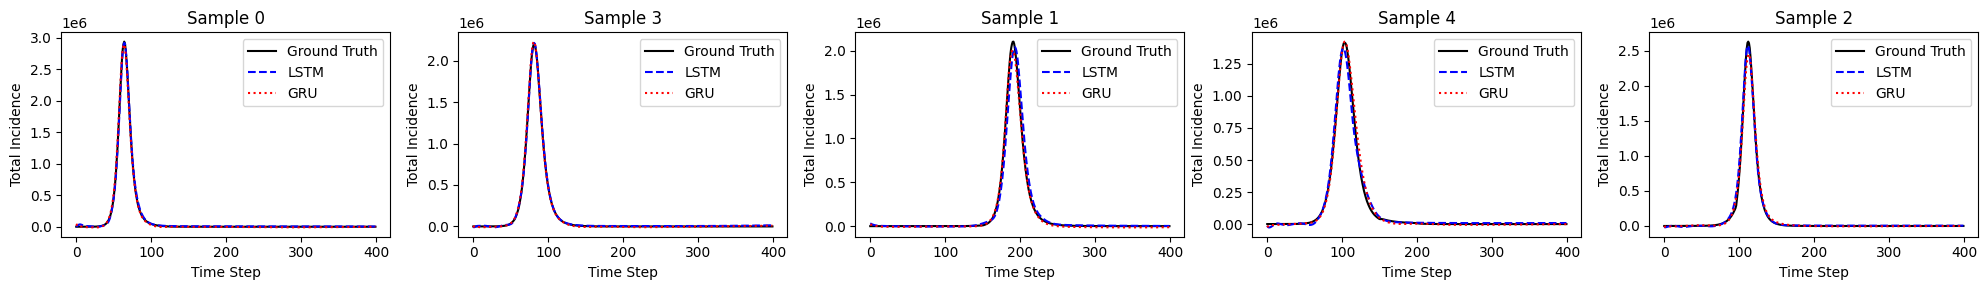

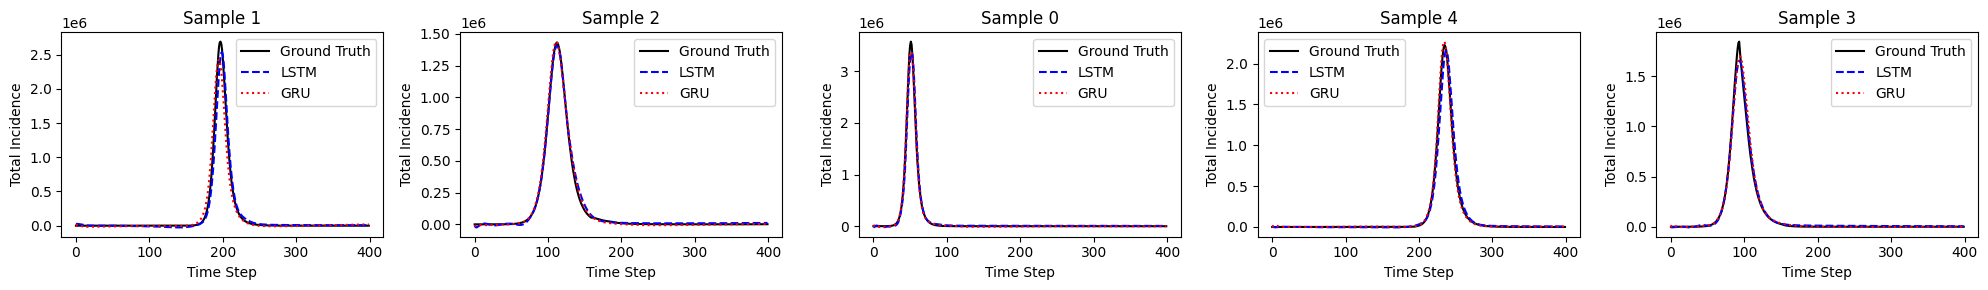

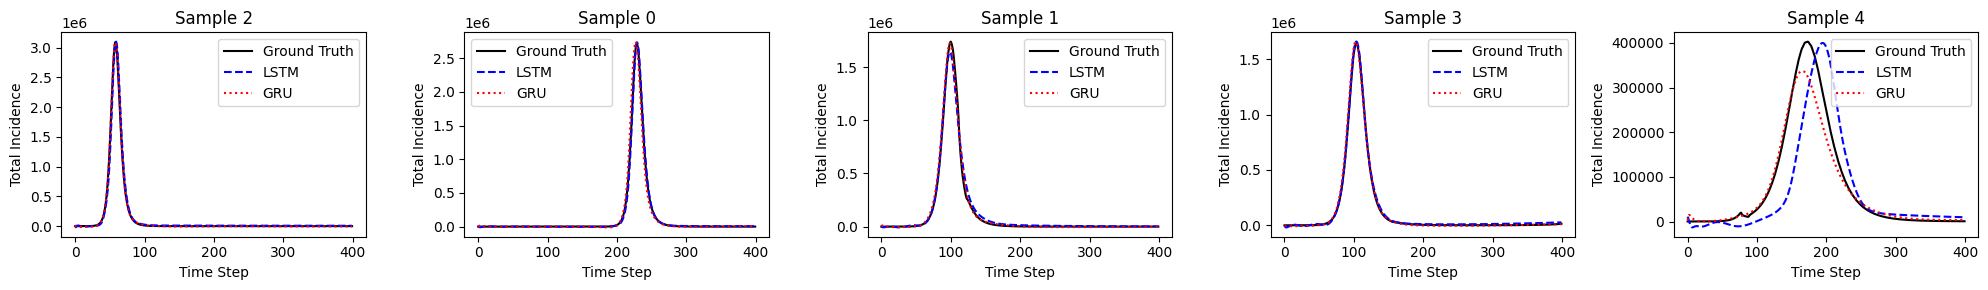

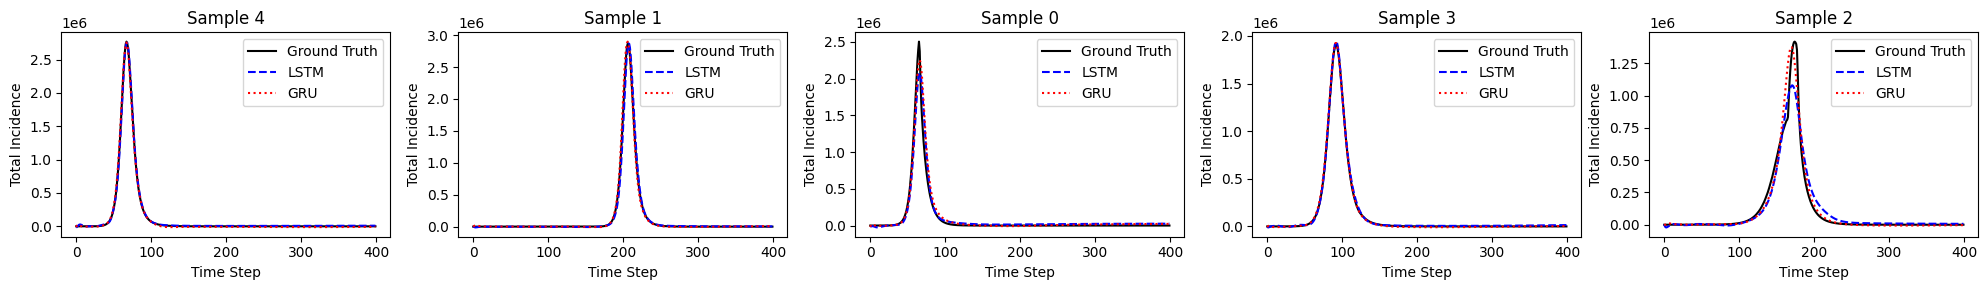

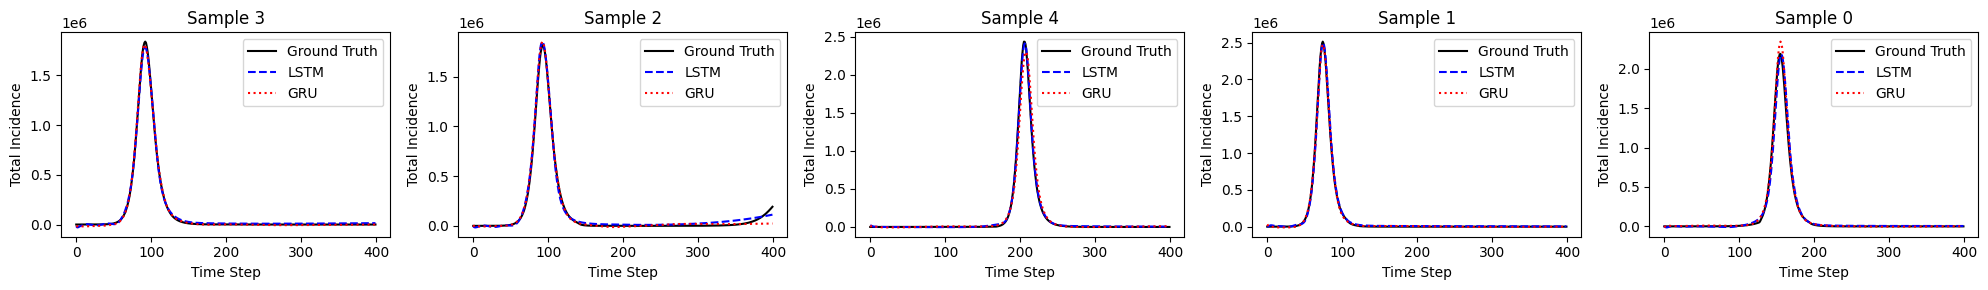

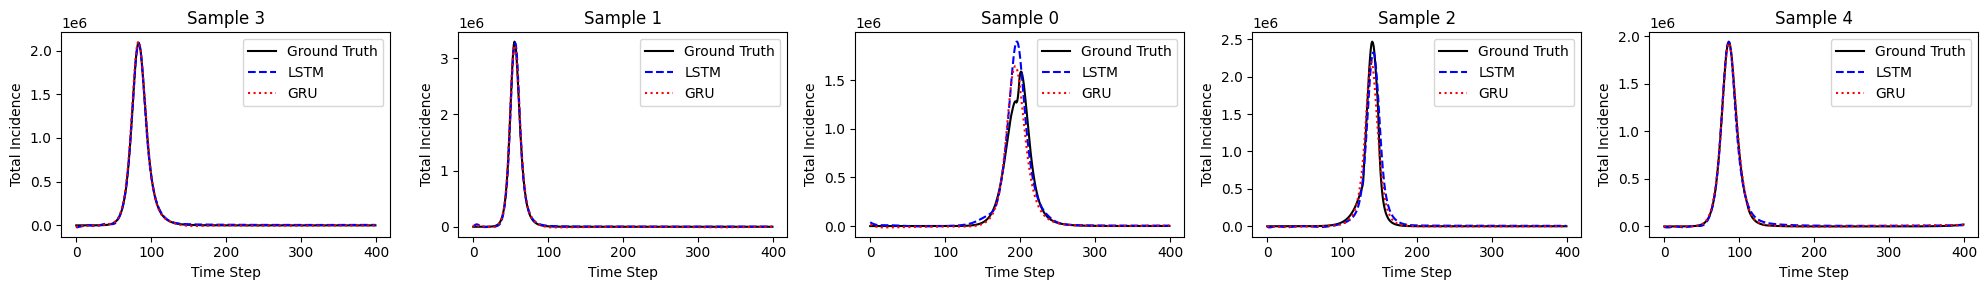

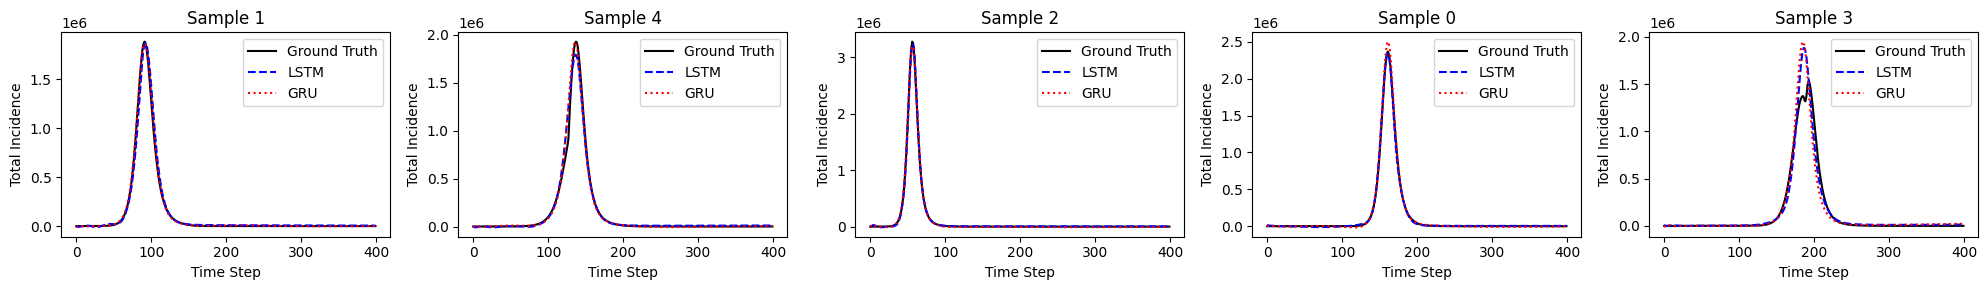

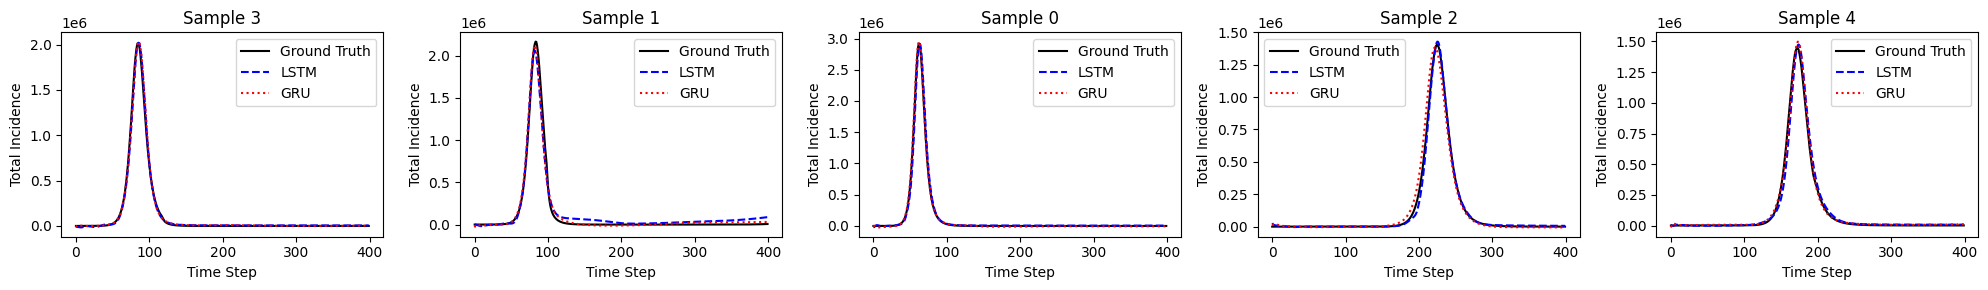

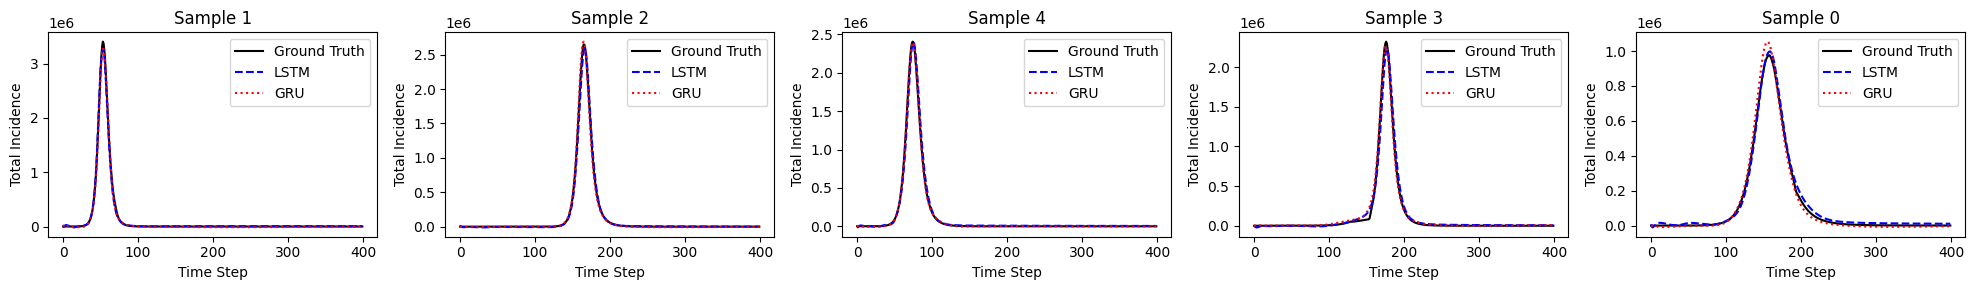

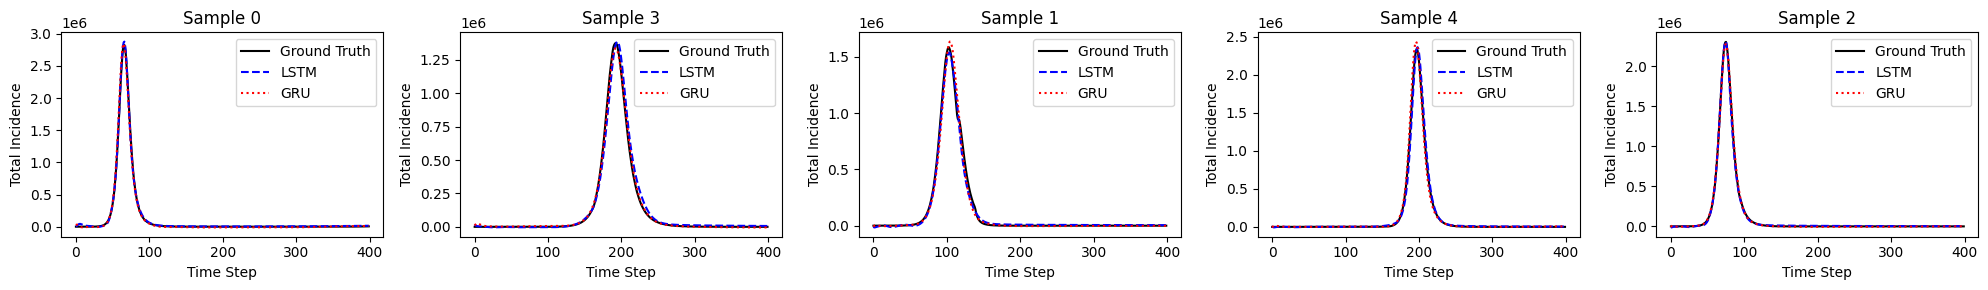

In [48]:
# Evaluate on additional test samples
for i in range(10):
    n_samples = 5
    test_results = sample_and_run_models(
        n_samples,
        contact_matrix,
        N,
        I0,
        t_end,
        latent_range,
        infectious_range,
        immunity_range,
        Rt_range,
        tt_Rt_range,
        dt=0.1,
    )
    val_dataset = SEIRTimeSeriesDataset(
        test_results, x_scaler=x_scaler, y_scaler=y_scaler
    )
    batch_size = 32
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    plot_predictions(
        model_lstm, model_gru, val_dataset, device, y_scaler, n_samples=n_samples
    )

## Conclusion

In this notebook we:

- Introduced the theory behind infectious disease (ID) modelling with the SEIR compartmental framework.
- Discussed the benefits of surrogate models to approximate expensive simulations.
- Reviewed the basics of RNNs and provided detailed equations for LSTM and GRU cells.
- Demonstrated parameter exploration using Latin Hypercube Sampling (LHS).
- Trained and compared two surrogate models (one based on LSTM and one on GRU) to predict the SEIR simulation output.

This integrated approach can be extended to other epidemiological models and serves as a foundation for rapid prediction and uncertainty quantification in infectious disease dynamics.
